# Install and import packages

In [1]:
!pip install scikit-bio
!pip install shap
!pip install pymrmr
!pip install eli5
!pip install scikit-optimize
!pip install catboost==0.13
!pip install scikit-learn==0.23.2
!pip install lightgbm

In [508]:
# data representation
import pandas as pd
import numpy as np
import scipy.stats as sts

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# data preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle

# feature engineering
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

import shap as sp
import pymrmr
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.feature_selection import f_classif, SelectFromModel
from sklearn.inspection import permutation_importance
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest

# model selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV

# ML models
from sklearn.linear_model import LogisticRegressionCV, LinearRegression, RidgeCV, LassoCV, ElasticNetCV, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.svm import SVC, LinearSVC
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

# model metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score,\
        roc_curve, confusion_matrix, precision_recall_curve, auc, f1_score, precision_score, recall_score

# other
import skbio as sb
from tqdm import tqdm



# Data import and pre-processing

## MGX data

In [8]:
# load the data
def get_omics(link):
    profile = pd.read_csv(link, delimiter='\t', header=0).T
    # get the names of all features
    names = profile.iloc[0, :]
    # rename columns
    profile.columns = names
    profile = profile.iloc[1:,:]
    profile = profile.reset_index(drop=False)
    profile.rename(columns = {'index': 'External ID'},  
          inplace = True)
    # sort the samples by sample ID
    profile = profile.sort_values(by='External ID', axis=0, ascending=True).reset_index(drop=True)
    
#     print(link)
#     print(profile.shape)
#     print(names)
#     print(profile.iloc[:5, :5])
    return profile.reset_index(drop=True), names

In [9]:
# get MGX OTU
mgx_otu, mgx_otu_names = get_omics('mgx_taxonomic_profiles.tsv')

In [10]:
# mgx_otu = mgx_otu.set_index('External ID')
mgx_otu.head()

#SampleID External ID k__Archaea k__Archaea|p__Euryarchaeota  \
0          CSM5FZ3N_P          0                           0   
1          CSM5FZ3R_P          0                           0   
2          CSM5FZ3T_P          0                           0   
3          CSM5FZ3V_P          0                           0   
4          CSM5FZ3X_P          0                           0   

#SampleID k__Archaea|p__Euryarchaeota|c__Methanobacteria  \
0                                                      0   
1                                                      0   
2                                                      0   
3                                                      0   
4                                                      0   

#SampleID k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales  \
0                                                          0                     
1                                                          0                     
2                                                          0                     
3                                                          0                     
4                                                          0                     

#SampleID k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae  \
0                                                          0                                            
1                                                          0                                            
2                                                          0                                            
3                                                          0                                            
4                                                          0                                            

#SampleID k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter  \
0                                                          0                                                                  
1                                                          0                                                                  
2                                                          0                                                                  
3                                                          0                                                                  
4                                                          0                                                                  

#SampleID k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii  \
0                                                          0                                                                                                
1                                                          0                                                                                                
2                                                          0                                                                                                
3                                                          0                                                                                                
4                                                          0                                                                                                

#SampleID k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobrevibacter|s__Methanobrevibacter_smithii|t__Methanobrevibacter_smithii_unclassified  \
0                                                          0                                                                                                                                           
1                       

In [11]:
mgx_otu_copy = mgx_otu.copy()

In [12]:
gen = ['External ID']
gen_short = ['External ID']
for col in mgx_otu_copy.columns[1:]:
    if 'g__' in col:
        if 's__' not in col:
            gen.append(col)
            ind = col.find('g__')
            g = col[ind:]
            gen_short.append(g)
            
mgx_otu_copy = mgx_otu_copy[gen]
mgx_otu_copy.columns = gen_short

In [13]:
mgx_otu_copy.head()

External ID g__Methanobrevibacter g__Granulicella g__Terriglobus  \
0  CSM5FZ3N_P                     0               0              0   
1  CSM5FZ3R_P                     0               0              0   
2  CSM5FZ3T_P                     0               0              0   
3  CSM5FZ3V_P                     0               0              0   
4  CSM5FZ3X_P                     0               0              0   

  g__Actinobaculum g__Actinomyces g__Varibaculum g__Brevibacterium  \
0                0              0              0                 0   
1                0              0              0                 0   
2                0              0              0                 0   
3                0              0              0                 0   
4                0              0              0                 0   

  g__Corynebacterium g__Brachybacterium  ... g__Anelloviridae_noname  \
0                  0                  0  ...                       0   
1                  0                  0  ...                       0   
2                  0                  0  ...                       0   
3                  0                  0  ...                       0   
4                  0                  0  ...                       0   

  g__Gyrovirus g__Microvirus g__Alphacryptovirus g__Potyvirus  \
0            0             0                   0            0   
1            0             0                   0            0   
2            0             0                   0    0.0001166   
3            0             0                   0            0   
4            0             0                   0            0   

  g__Alpharetrovirus g__Betaretrovirus g__Gammaretrovirus  \
0                  0                 0                  0   
1                  0                 0                  0   
2                  0                 0                  0   
3                  0                 0                  0   
4                  0                 0                  0   

  g__Retroviridae_noname g__Viruses_noname  
0                      0                 0  
1                      0                 0  
2                      0                 0  
3                      0                 0  
4                      0                 0  

[5 rows x 200 columns]

## Metadata

In [14]:
# import metadata
metadata = pd.read_csv('hmp2_metadata.csv')
metadata['diseased'] = metadata['diagnosis'].replace({'UC': 1, 'CD': 1, 'nonIBD': 0})

Columns (12,13,14,40,46,55,65,66,67,68,177,294,298,299,300,301,304,305,306,307,308,309,310,318,320,328,330,346,348,350,352,354,359,361,363,366,373,377,381,383,418,419,432,433,434,435,436,438,439,440,441,442,444,445,446,447,448,450,451,452,453,454) have mixed types.Specify dtype option on import or set low_memory=False.


In [15]:
# metadata head
metadata.iloc[:10, :10].head()

Project External ID Participant ID site_sub_coll   data_type  \
0  C3001CSC1_BP      206615          C3001     C3001CSC1  biopsy_16S   
1  C3001CSC2_BP      206614          C3001     C3001CSC2  biopsy_16S   
2  C3002CSC1_BP      206617          C3002     C3002CSC1  biopsy_16S   
3  C3002CSC2_BP      206619          C3002     C3002CSC2  biopsy_16S   
4  C3002CSC3_BP      206616          C3002     C3002CSC3  biopsy_16S   

   week_num date_of_receipt  interval_days  visit_num Research Project  
0       2.0             NaN            NaN          1           ibdmdb  
1       2.0             NaN            NaN          1           ibdmdb  
2       0.0             NaN            NaN          1           ibdmdb  
3       0.0             NaN            NaN          1           ibdmdb  
4       0.0             NaN            NaN          1           ibdmdb

In [16]:
# check out metadata columns
metadata.columns

Index(['Project', 'External ID', 'Participant ID', 'site_sub_coll',
       'data_type', 'week_num', 'date_of_receipt', 'interval_days',
       'visit_num', 'Research Project',
       ...
       'Proteomics received at LBNL:', 'Stool Sample ID:  Tube A  (EtOH)',
       'Sample ID: Tube B (No preservative)',
       'Tube A and B received at Broad:', 'stool_id', 'smoking status',
       'Number years smoked', 'Age when started smoking',
       'How many cigarettes/cigars/etc. do you smoke per day?', 'diseased'],
      dtype='object', length=491)

In [17]:
# get microbiome data types, such as 16S, MGX, MTX,...
data_types = metadata['data_type'].unique()

In [18]:
# get the particular metadata for each data type
def get_meta(data):
    meta = metadata[metadata['data_type'] == data]
    # sort metadata by sample ID
    meta = meta.sort_values(by='External ID', axis=0, ascending=True).reset_index(drop=True)
#     print('# of samples', meta.shape[0])
#     print('# of participants', len(meta['Participant ID'].unique()))
#     print('# of diseased', meta['diagnosis'].value_counts(normalize=True))
    return meta

In [19]:
# get and inspect each type of data
meta = {}
for each in data_types:
#     print(each)
    meta[each] = get_meta(each)

## Combined data

In [20]:
data_types

array(['biopsy_16S', 'host_genome', 'host_transcriptomics',
       'metabolomics', 'metagenomics', 'metatranscriptomics', 'methylome',
       'proteomics', 'serology', 'stool_16S', 'viromics'], dtype=object)

In [21]:
# assign each metadata subset to a variable
mgx_meta = meta['metagenomics']
mtx_meta = meta['metatranscriptomics']
mbx_meta = meta['metabolomics']
mvx_meta = meta['viromics']

In [22]:
mgx_meta.head()

Project External ID Participant ID site_sub_coll     data_type  week_num  \
0  G79889  CSM5FZ3N_P          C3001       C3001C1  metagenomics       0.0   
1  G79894  CSM5FZ3R_P          C3001       C3001C2  metagenomics       2.0   
2  G79914  CSM5FZ3T_P          C3002       C3002C1  metagenomics       0.0   
3  G79913  CSM5FZ3V_P          C3001       C3001C4  metagenomics       6.0   
4  G79929  CSM5FZ3X_P          C3002       C3002C2  metagenomics       2.0   

  date_of_receipt  interval_days  visit_num Research Project  ...  \
0      2014-03-14            0.0          4           ibdmdb  ...   
1      2014-03-28           14.0          5           ibdmdb  ...   
2      2014-04-29            0.0          4           ibdmdb  ...   
3      2014-04-28           13.0          7           ibdmdb  ...   
4      2014-05-13           14.0          5           ibdmdb  ...   

  Proteomics received at LBNL:  Stool Sample ID:  Tube A  (EtOH)  \
0                           No                          SM-5FZ3N   
1                           No                          SM-5FZ3R   
2                           No                          SM-5FZ3T   
3                           No                          SM-5FZ3V   
4                           No                          SM-5FZ3X   

  Sample ID: Tube B (No preservative) Tube A and B received at Broad:  \
0                            SM-5FZ3P                              No   
1                            SM-5UJBB                             Yes   
2                            SM-5FZ3U                             Yes   
3                            SM-5FZ3W                             Yes   
4                            SM-5FZ3Y                             Yes   

  stool_id  smoking status  Number years smoked  Age when started smoking  \
0      NaN             NaN                  NaN                       NaN   
1      NaN             NaN                  NaN                       NaN   
2      NaN             NaN                  NaN                       NaN   
3      NaN             NaN                  NaN                       NaN   
4      NaN             NaN                  NaN                       NaN   

   How many cigarettes/cigars/etc. do you smoke per day?  diseased  
0                                                NaN             1  
1                                                NaN             1  
2                                                NaN             1  
3                                                NaN             1  
4                                                NaN             1  

[5 rows x 491 columns]

In [23]:
# merge MGX OTU with metadata
mgx_otu_d = pd.merge(mgx_meta[['External ID', 'Participant ID', 'date_of_receipt', 'diseased']], mgx_otu_copy,  on=['External ID'])
mgx_otu_d = mgx_otu_d.set_index('External ID')
mgx_otu_d.iloc[:5, :10]

Participant ID date_of_receipt  diseased g__Methanobrevibacter  \
External ID                                                                  
CSM5FZ3N_P           C3001      2014-03-14         1                     0   
CSM5FZ3R_P           C3001      2014-03-28         1                     0   
CSM5FZ3T_P           C3002      2014-04-29         1                     0   
CSM5FZ3V_P           C3001      2014-04-28         1                     0   
CSM5FZ3X_P           C3002      2014-05-13         1                     0   

            g__Granulicella g__Terriglobus g__Actinobaculum g__Actinomyces  \
External ID                                                                  
CSM5FZ3N_P                0              0                0              0   
CSM5FZ3R_P                0              0                0              0   
CSM5FZ3T_P                0              0                0              0   
CSM5FZ3V_P                0              0                0              0   
CSM5FZ3X_P                0              0                0              0   

            g__Varibaculum g__Brevibacterium  
External ID                                   
CSM5FZ3N_P               0                 0  
CSM5FZ3R_P               0                 0  
CSM5FZ3T_P               0                 0  
CSM5FZ3V_P               0                 0  
CSM5FZ3X_P               0                 0

In [24]:
# collapse MGX OTU data to sample-time level
mgx_cols = mgx_otu_d.columns
mgx_otu_d_mean = mgx_otu_d[mgx_cols].groupby(['Participant ID', 'date_of_receipt']).mean(numeric_only=False)

In [25]:
mgx_otu_d_mean = mgx_otu_d_mean.reset_index(level=[0,1]).drop(columns=['date_of_receipt'])

In [26]:
mgx_otu_d_mean.iloc[:5, :5]

Participant ID  diseased  g__Methanobrevibacter  g__Granulicella  \
0          C3001         1                    0.0              0.0   
1          C3001         1                    0.0              0.0   
2          C3001         1                    0.0              0.0   
3          C3001         1                    0.0              0.0   
4          C3001         1                    0.0              0.0   

   g__Terriglobus  
0             0.0  
1             0.0  
2             0.0  
3             0.0  
4             0.0

# Preliminary analysis

## Distribution of number of samples

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


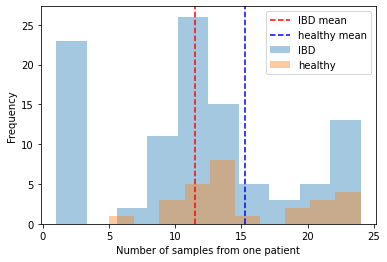

In [103]:
# plotting distribution
sns.distplot(mgx_otu_d_mean[['Participant ID', 'diseased']][mgx_otu_d_mean['diseased']==1].groupby('Participant ID').count()['diseased'],bins=10,kde=False, hist=True, label='IBD')
sns.distplot(mgx_otu_d_mean[['Participant ID', 'diseased']][mgx_otu_d_mean['diseased']==0].groupby('Participant ID').count()['diseased'],bins=10,kde=False, hist=True, label='healthy')
plt.axvline(np.mean(mgx_otu_d_mean[['Participant ID', 'diseased']][mgx_otu_d_mean['diseased']==1].groupby('Participant ID').count()['diseased']), label='IBD mean', color='red', linestyle='--')
plt.axvline(np.mean(mgx_otu_d_mean[['Participant ID', 'diseased']][mgx_otu_d_mean['diseased']==0].groupby('Participant ID').count()['diseased']), label='healthy mean', color='blue', linestyle='--')
plt.xlabel('Number of samples from one patient')
plt.ylabel('Frequency')
plt.legend()

In [109]:
# get participants with few samples
count_samples_diseased = mgx_otu_d_mean[['Participant ID', 'diseased']][mgx_otu_d_mean['diseased']==1].groupby('Participant ID').count()
few_samples = list(count_samples_diseased[count_samples_diseased['diseased'] < 5].index)                                     

In [110]:
# drop few sample participants
mgx_otu_d_mean_reduced = mgx_otu_d_mean[~mgx_otu_d_mean['Participant ID'].isin(few_samples)]
X_all = mgx_otu_d_mean_reduced.drop(columns=['diseased'])
y_all = mgx_otu_d_mean_reduced[['Participant ID', 'diseased']]

In [114]:
print('Number of diseased participants')
mgx_otu_d_mean_reduced[['Participant ID', 'diseased']][mgx_otu_d_mean_reduced['diseased']==1].groupby('Participant ID').first()['diseased'].shape[0]

Number of diseased participants


80

In [115]:
print('Number of healthy participants')
mgx_otu_d_mean_reduced[['Participant ID', 'diseased']][mgx_otu_d_mean_reduced['diseased']==0].groupby('Participant ID').first()['diseased'].shape[0]

Number of healthy participants


27

In [117]:
print('Number of diseased and healthy samples')
y_all['diseased'].value_counts()

Number of diseased and healthy samples


1    1150
0     413
Name: diseased, dtype: int64

In [206]:
mgx_otu_d_mean = mgx_otu_d_mean_reduced

## Overall abundance of all genera

[Text(0.5, 1.0, '20 most abundant genera')]

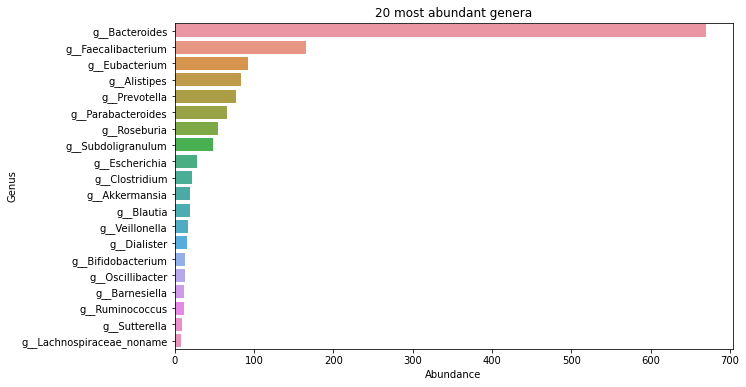

In [207]:
# See overall abundance of each genus
df = pd.DataFrame(mgx_otu_d_mean.drop(columns=['Participant ID', 'diseased']).sum(axis=0).sort_values(ascending=False)).reset_index()
df.columns = ['Genus', 'Abundance']
plt.figure(figsize=(10,6))
sns.barplot(data = df.iloc[:20], y = 'Genus', x = 'Abundance', orient = 'h').set(title=f'20 most abundant genera')

[Text(0.5, 1.0, '20 most abundant genera for healthy')]

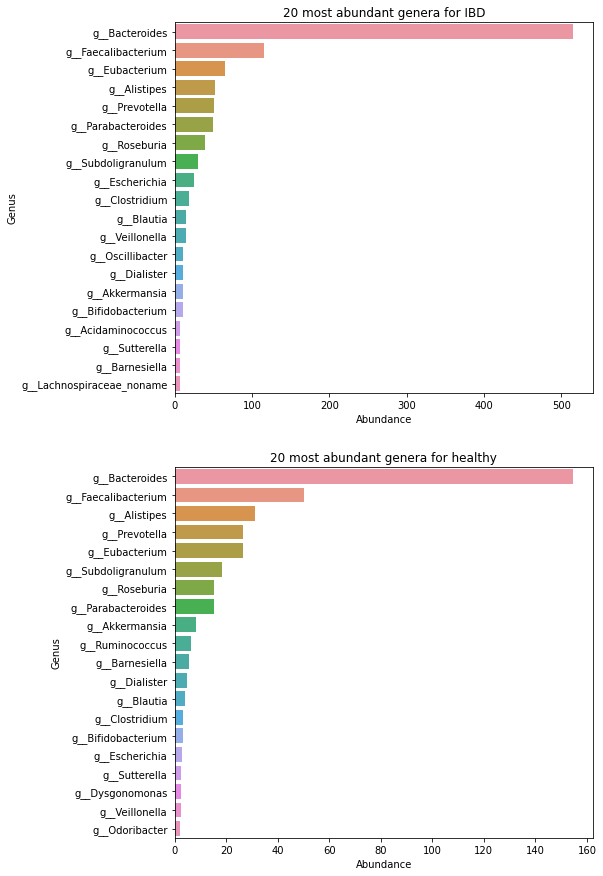

In [504]:
# See overall abundance of each genus in each class
df1 = pd.DataFrame(mgx_otu_d_mean[mgx_otu_d_mean['diseased']==1].drop(columns=['Participant ID', 'diseased']).sum(axis=0).sort_values(ascending=False)).reset_index()
df1.columns = ['Genus', 'Abundance']
df0 = pd.DataFrame(mgx_otu_d_mean[mgx_otu_d_mean['diseased']==0].drop(columns=['Participant ID', 'diseased']).sum(axis=0).sort_values(ascending=False)).reset_index()
df0.columns = ['Genus', 'Abundance']

plt.figure(figsize=(7.5,15))
plt.subplot(2,1,1)
sns.barplot(data = df1.iloc[:20], y = 'Genus', x = 'Abundance', orient = 'h').set(title=f'20 most abundant genera for IBD')
plt.subplot(2,1,2)
sns.barplot(data = df0.iloc[:20], y = 'Genus', x = 'Abundance', orient = 'h').set(title=f'20 most abundant genera for healthy')

## Distribution of some genera

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


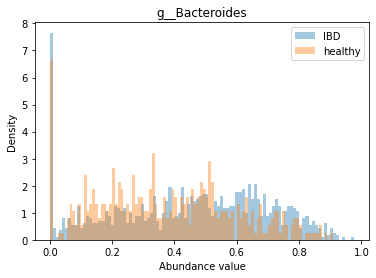

KstestResult(statistic=0.1875544794188862, pvalue=7.903701026990007e-10)


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


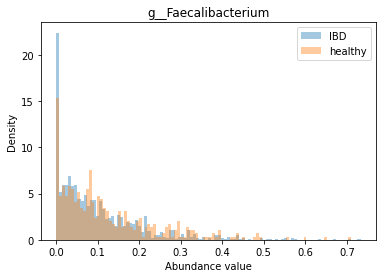

KstestResult(statistic=0.10725339509422044, pvalue=0.0016715401748270686)


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


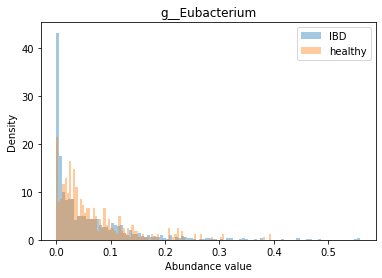

KstestResult(statistic=0.20646804926834403, pvalue=7.892797526665163e-12)


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


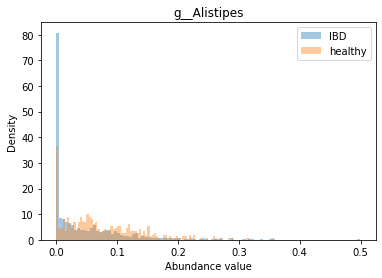

KstestResult(statistic=0.30530582166543846, pvalue=1.2008737193254909e-25)


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


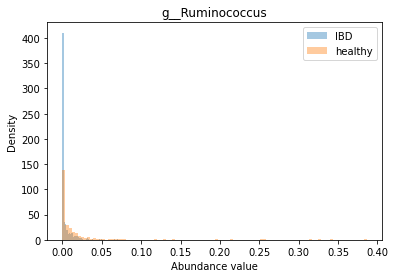

KstestResult(statistic=0.28433098220865355, pvalue=3.0548724169330613e-22)


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


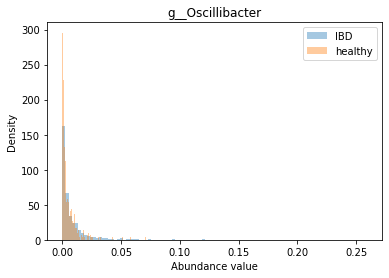

KstestResult(statistic=0.13470681124328876, pvalue=2.830095346839645e-05)


In [518]:
# Plot the distribution of several genera
eps = 10**-100
def dist(g):
    plt.figure(figsize=(6,4))
    
    sns.distplot(mgx_otu_d_mean[mgx_otu_d_mean['diseased']==1][g],kde=False,bins=100, norm_hist=True, label='IBD')
#     plt.figure(figsize=(6,4))
    sns.distplot(mgx_otu_d_mean[mgx_otu_d_mean['diseased']==0][g],kde=False,bins=100, norm_hist=True, label='healthy')
    plt.title(g)
    plt.legend()
    plt.xlabel('Abundance value')
    plt.ylabel('Density')

    plt.show()
    print(sts.kstest(mgx_otu_d_mean[mgx_otu_d_mean['diseased']==1][g], mgx_otu_d_mean[mgx_otu_d_mean['diseased']==0][g]))

dist('g__Bacteroides')
dist('g__Faecalibacterium')
dist('g__Eubacterium')

dist('g__Alistipes')
dist('g__Ruminococcus')
dist('g__Oscillibacter')

# Classification pipeline

## Split and visualize data

### Split data

In [350]:
# split the data 
def patient_split(X, y):
    
    # proxy for diseased and healthy number
    a = 1
    b = 1
    
    # reset index
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    # check if the ratio satistfies
    while a/b > 3 or a/b < 2.5:
        
        # get unique ID
        patients = set(X['Participant ID'].unique())
        n = len(patients)
        
        # get a random set of IDs for train and test
        train = set(np.random.choice(list(patients), int(np.ceil(n*np.random.uniform(2.75/4, 3/4))), replace=False))
        test = patients - train
        
        # obtain train and test data
        X_train, X_test, y_train, y_test =  X[X['Participant ID'].isin(train)], X[X['Participant ID'].isin(test)],\
        y[y['Participant ID'].isin(train)], y[y['Participant ID'].isin(test)]
        
        a = y_train['diseased'].value_counts().iloc[0]
        b = y_train['diseased'].value_counts().iloc[1]
        
    return X_train, X_test, y_train, y_test, list(X_train.index), list(X_test.index)

### PCA plot

In [219]:
# plot clustering of healthy and diseased
def plot_2d_space(X, y):
    y = y.to_numpy().ravel()

    # pca transform the features
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    colors = ['red', 'blue', 'black']
    markers = ['o', 's', 'x']

    # plot data in 2 dimensions
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X_pca[y==l, 0],
            X_pca[y==l, 1],
            c=c, label=l, marker=m
        )
        
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.title('PCA plot for data')
    plt.legend(loc='upper right')
    plt.show()

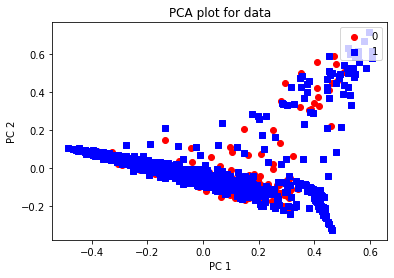

In [220]:
X_train_plot, X_test_plot, y_train_plot, y_test_plot, _, _ = patient_split(X_all, y_all)
plot_2d_space(X_train_plot.drop(columns=['Participant ID']), y_train_plot.drop(columns=['Participant ID']))

## Correlation & covariance

In [118]:
X_all['Participant ID'][y_all['diseased']==0].value_counts().iloc[:5]

P6018    24
M2072    24
M2084    23
M2042    23
H4023    22
Name: Participant ID, dtype: int64

In [119]:
X_all['Participant ID'][y_all['diseased']==1].value_counts().iloc[:5]

H4019    24
M2069    24
M2068    24
H4035    24
P6013    23
Name: Participant ID, dtype: int64

In [120]:
X_all.to_csv('X_all.csv')
y_all.to_csv('y_all.csv')

In [33]:
# X_all = pd.read_csv('X_all.csv')
# y_all = pd.read_csv('y_all.csv')

### Intrapatient correlation

Text(0.5, 1.0, 'Participant H4019, healthy')

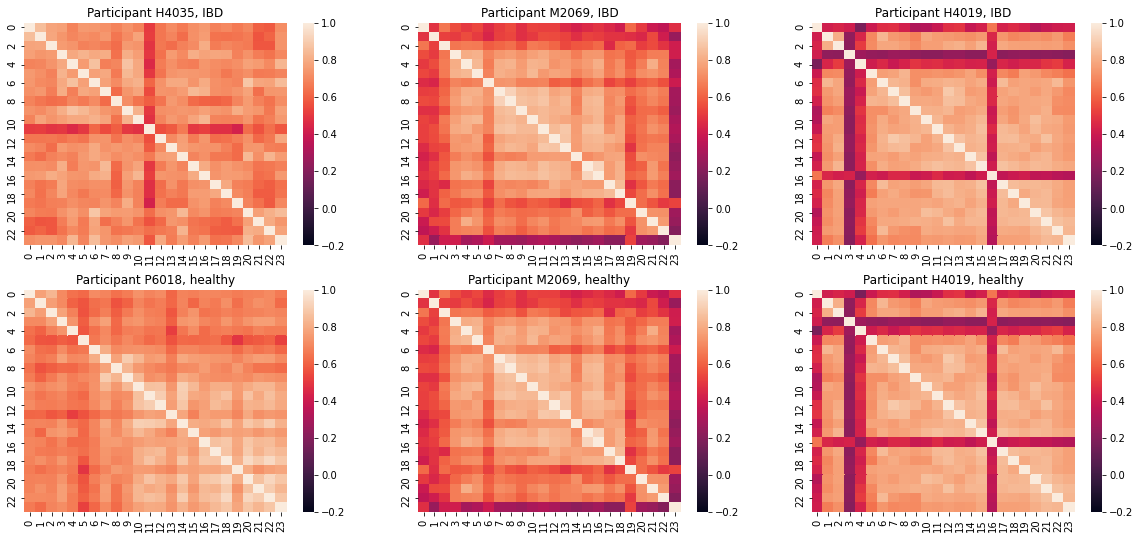

In [291]:
plt.figure(figsize=(20,9))

plt.subplot(2,3,1)
H4035 = X_all[X_all['Participant ID']=='H4035'].drop(columns=['Participant ID']).reset_index(drop=True).T
sns.heatmap(H4035.corr(method='kendall'), annot=False, vmax=1, vmin=-0.2)
plt.title('Participant H4035, IBD')

plt.subplot(2,3,2)
M2069 = X_all[X_all['Participant ID']=='M2069'].drop(columns=['Participant ID']).reset_index(drop=True).T
sns.heatmap(M2069.corr(method='kendall'), annot=False, vmax=1, vmin=-0.2)
plt.title('Participant M2069, IBD')

plt.subplot(2,3,3)
H4019 = X_all[X_all['Participant ID']=='H4019'].drop(columns=['Participant ID']).reset_index(drop=True).T
sns.heatmap(H4019.corr(method='kendall'), annot=False, vmax=1, vmin=-0.2)
plt.title('Participant H4019, IBD')

plt.subplot(2,3,4)
P6018 = X_all[X_all['Participant ID']=='P6018'].drop(columns=['Participant ID']).reset_index(drop=True).T
sns.heatmap(P6018.corr(method='kendall'), annot=False, vmax=1, vmin=-0.2)
plt.title('Participant P6018, healthy')

plt.subplot(2,3,5)
M2069 = X_all[X_all['Participant ID']=='M2069'].drop(columns=['Participant ID']).reset_index(drop=True).T
sns.heatmap(M2069.corr(method='kendall'), annot=False, vmax=1, vmin=-0.2)
plt.title('Participant M2069, healthy')

plt.subplot(2,3,6)
H4019 = X_all[X_all['Participant ID']=='H4019'].drop(columns=['Participant ID']).reset_index(drop=True).T
sns.heatmap(H4019.corr(method='kendall'), annot=False, vmax=1, vmin=-0.2)
plt.title('Participant H4019, healthy')

### Interpatient correlation

#### Sample means

Text(0.5, 1.0, 'Interpatient correlation for healthy, sample mean')

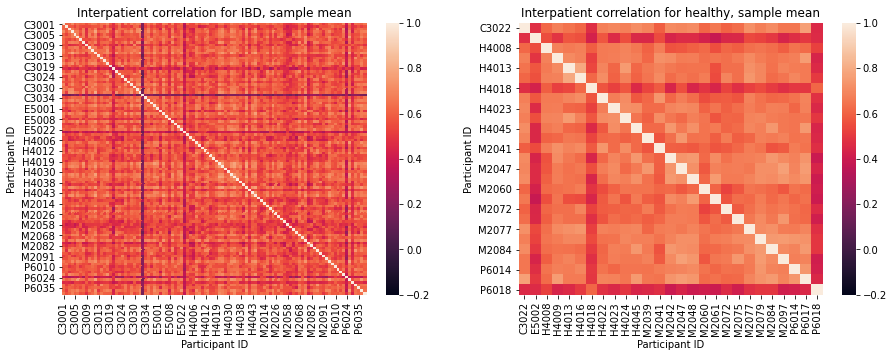

In [39]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
X_all_diseased_mean = X_all[y_all['diseased']==1].groupby(['Participant ID']).mean(numeric_only=False)
sns.heatmap(X_all_diseased_mean.T.corr(method='kendall'), annot=False, vmax=1, vmin=-0.2)
plt.title('Interpatient correlation for IBD, sample mean')

plt.subplot(1,2,2)
X_all_healthy_mean = X_all[y_all['diseased']==0].groupby(['Participant ID']).mean(numeric_only=False)
sns.heatmap(X_all_healthy_mean.T.corr(method='kendall'), annot=False, vmax=1, vmin=-0.2)
plt.title('Interpatient correlation for healthy, sample mean')

#### First sample

Text(0.5, 1.0, 'Interpatient correlation for healthy, first sample')

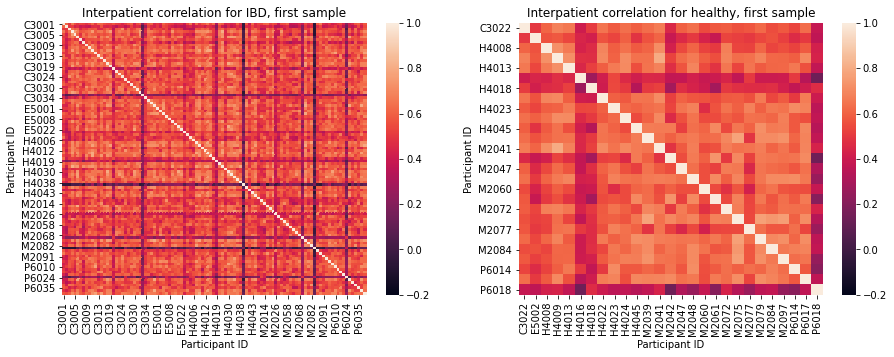

In [40]:
plt.figure(figsize=(15, 5))

plt.subplot(1,2,1)
X_all_diseased_first = X_all[y_all['diseased']==1].groupby(['Participant ID']).first()
sns.heatmap(X_all_diseased_first.T.corr(method='kendall'), annot=False, vmax=1, vmin=-0.2)
plt.title('Interpatient correlation for IBD, first sample')

plt.subplot(1,2,2)
X_all_healthy_first = X_all[y_all['diseased']==0].groupby(['Participant ID']).first()
sns.heatmap(X_all_healthy_first.T.corr(method='kendall'), annot=False, vmax=1, vmin=-0.2)
plt.title('Interpatient correlation for healthy, first sample')

### Feature correlation

Text(0.5, 1.0, 'Genera correlation for healthy, all samples')

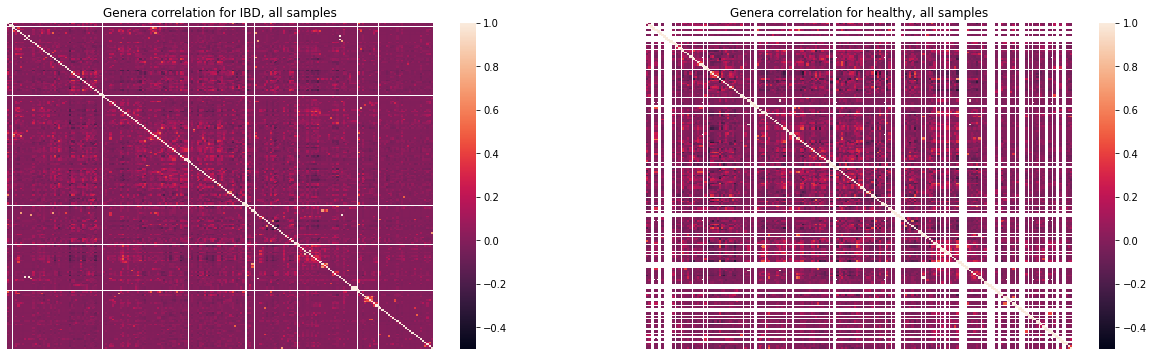

In [503]:
plt.figure(figsize=(21, 6))

plt.subplot(1,2,1)
X_all_diseased_all = X_all[y_all['diseased']==1]
sns.heatmap(X_all_diseased_all.corr(method='kendall'), xticklabels=False, yticklabels=False, annot=False, vmax=1, vmin=-0.5)
plt.title('Genera correlation for IBD, all samples')

plt.subplot(1,2,2)
X_all_healthy_all = X_all[y_all['diseased']==0]
sns.heatmap(X_all_healthy_all.corr(method='kendall'), xticklabels=False, yticklabels=False, annot=False, vmax=1, vmin=-0.5)
plt.title('Genera correlation for healthy, all samples')

Text(0.5, 1.0, 'Genera correlation for healthy, sample mean')

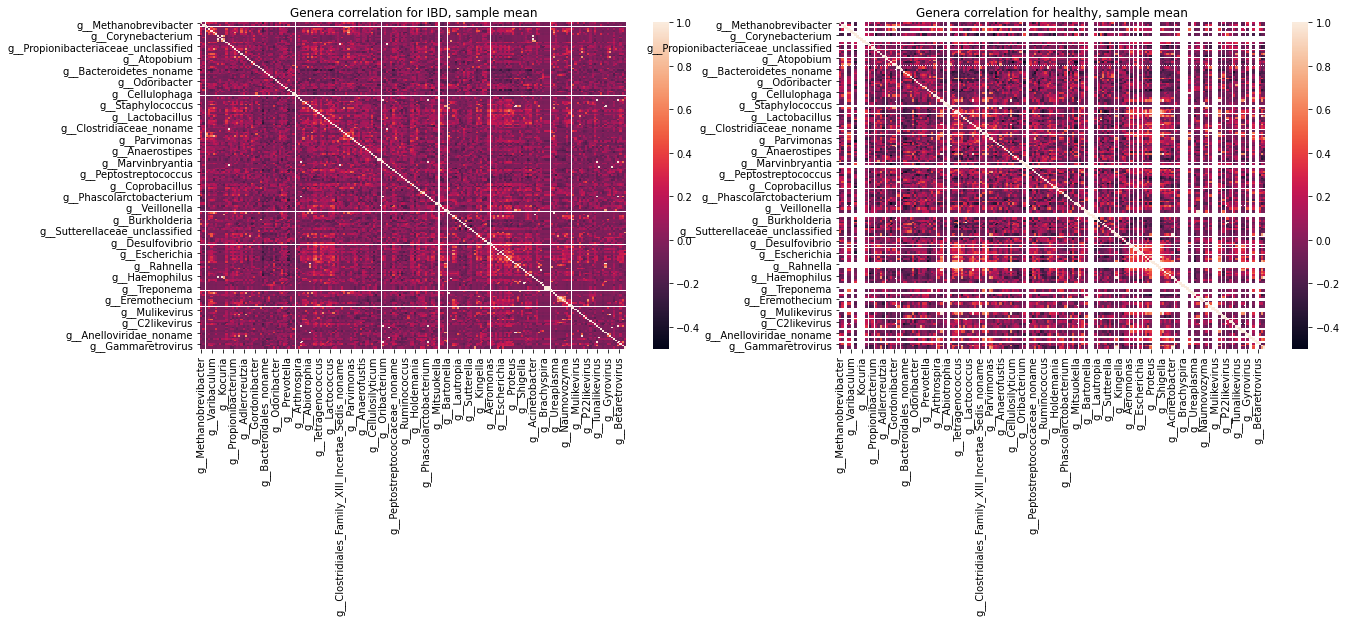

In [122]:
plt.figure(figsize=(21, 6))

plt.subplot(1,2,1)
X_all_diseased_mean = X_all[y_all['diseased']==1].groupby(['Participant ID']).mean(numeric_only=False)
sns.heatmap(X_all_diseased_mean.corr(method='kendall'), annot=False, vmax=1, vmin=-0.5)
plt.title('Genera correlation for IBD, sample mean')

plt.subplot(1,2,2)
X_all_healthy_mean = X_all[y_all['diseased']==0].groupby(['Participant ID']).mean(numeric_only=False)
sns.heatmap(X_all_healthy_mean.corr(method='kendall'), annot=False, vmax=1, vmin=-0.5)
plt.title('Genera correlation for healthy, sample mean')

Text(0.5, 1.0, 'Genera correlation for healthy, first sample')

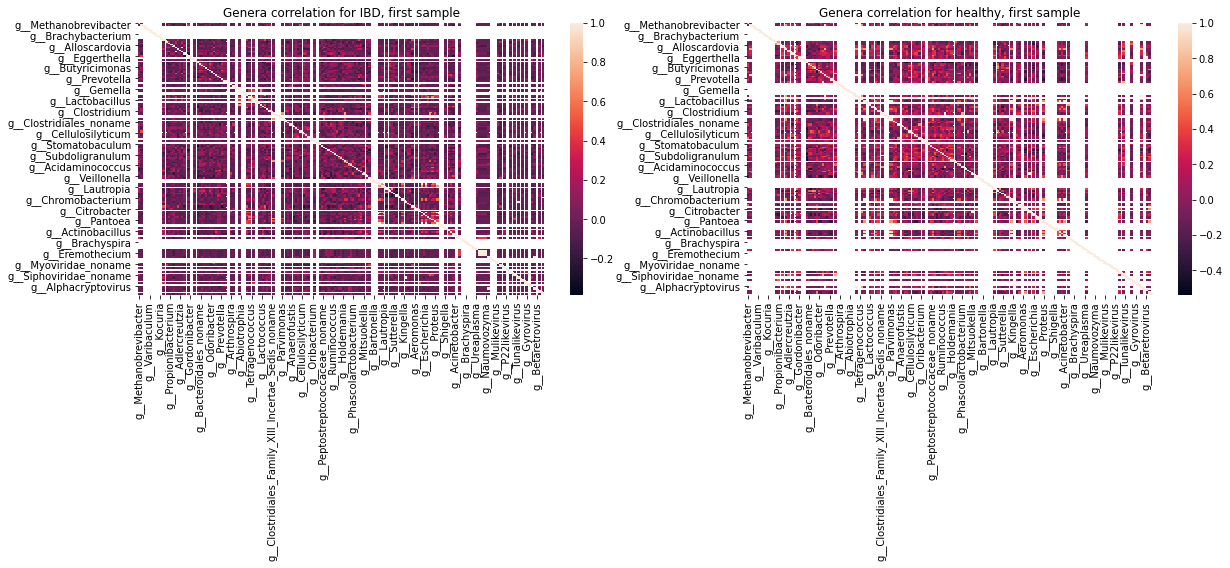

In [123]:
plt.figure(figsize=(20, 5))

plt.subplot(1,2,1)
X_all_diseased_first = X_all[y_all['diseased']==1].groupby(['Participant ID']).first()
sns.heatmap(X_all_diseased_first.corr(method='kendall'), annot=False)
plt.title('Genera correlation for IBD, first sample')

plt.subplot(1,2,2)
X_all_healthy_first = X_all[y_all['diseased']==0].groupby(['Participant ID']).first()
sns.heatmap(X_all_healthy_first.corr(method='kendall'), annot=False)
plt.title('Genera correlation for healthy, first sample')

## Feature selection and engineering

### Mutual info

In [44]:
# mutual info
def mutual_info(X, y, select_k):
    # use select k best algorithm
    selection = SelectKBest(mutual_info_classif, k=select_k).fit(X, y)
    features = X.columns[selection.get_support()]
    return features

## Classification and evaluation

### Building models

#### Support vector classifier

In [301]:
def svc(X_train_list, X_test_list, y_train_list, y_test_list, j, output=True, disable=False):
    
    models = []
    best_f1_0_list = []
    best_f1_1_list = []
    for i in tqdm(range(len(X_train_list)), disable=disable):
        # splitting data
        X_train, X_test, y_train, y_test = X_train_list[i], X_test_list[i], y_train_list[i], y_test_list[i]
        
        # storage
        f1_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        precision_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        recall_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        cm_mat = pd.DataFrame(columns = ['Threshold', 'Confusion matrix for train', 'Confusion matrix'])

        f10_i9 = []
        f11_i9 = []
        
        # training the model
        model = SVC(probability=True, kernel='linear')
        model.fit(X_train.drop(columns=['Participant ID']), y_train.drop(columns=['Participant ID']).to_numpy().ravel())
        
        # get probability scores
        y_train_score_1 = model.predict_proba(X_train.drop(columns=['Participant ID'])).T[1]
        
        y_test_score_1 = model.predict_proba(X_test.drop(columns=['Participant ID'])).T[1]
        y_test_score_0 = model.predict_proba(X_test.drop(columns=['Participant ID'])).T[0]
                         
        # get metrics
        precision1, recall1, thresholds1 = precision_recall_curve(y_test.drop(columns=['Participant ID']), y_test_score_1)
        precision0, recall0, thresholds0 = precision_recall_curve(y_test.drop(columns=['Participant ID']), y_test_score_0)

        pr_auc1 = "{:.2f}".format(auc(recall1, precision1))
        pr_auc0 = "{:.2f}".format(auc(recall0, precision0))

        prauc_mat = {'Class 0': pr_auc0, 'Class 1': pr_auc1}

        thres = list(np.linspace(0.3, 0.9, 8))
        
        best_f1_0 = 0
        best_f1_1 = 0
        proxy = 0
        
        # across different classification thresholds
        for h in thres:
            t = "{:.3f}".format(h)
            
            # train and test prediction
            y_train_pred = np.where(y_train_score_1 > h, 1, 0)
            y_test_pred = np.where(y_test_score_1 > h, 1, 0)
            f10, f11 = f1_score(y_test.drop(columns=['Participant ID']), y_test_pred, average = None)
            p0, p1 = precision_score(y_test.drop(columns=['Participant ID']), y_test_pred, average=None)
            r0, r1 = recall_score(y_test.drop(columns=['Participant ID']), y_test_pred, average=None)
            
            # append to storage
            f1_mat = f1_mat.append({'Threshold': t, 'Class 0': f10,\
                           'Class 1': f11}, ignore_index=True)
            precision_mat = precision_mat.append({'Threshold': t, 'Class 0': p0,\
                           'Class 1': p1}, ignore_index=True)
            recall_mat = recall_mat.append({'Threshold': t, 'Class 0': r0,\
                           'Class 1': r1}, ignore_index=True)
            cm_mat = cm_mat.append({'Threshold': t, \
                                    'Confusion matrix for train': confusion_matrix(y_train.drop(columns=['Participant ID']), y_train_pred),\
                               'Confusion matrix': confusion_matrix(y_test.drop(columns=['Participant ID']), y_test_pred)}, ignore_index=True)
            # get best pairs of F1
            if f10*f11 > proxy:
                proxy = f10*f11
                best_f1_0 = f10
                best_f1_1 = f11
                
            f10_i9.append(f10)
            f11_i9.append(f11)

        if output == True:
            # plot PR curve
            plt.figure()
            plt.plot(recall0, precision0, label='Class 0')
            plt.plot(recall1, precision1, label='Class 1')
            plt.xlabel('recall')
            plt.ylabel('precision')
            plt.title('PR curves for two classes')
            plt.legend()
            plt.show()
            
            # plot F1
            plt.figure()
            plt.plot(thres, f10_i9, label='Class 0')
            plt.plot(thres, f11_i9, label='Class 1')
            plt.xlabel('classification threshold')
            plt.ylabel('f1 score')
            plt.title('F1 scores for different thresholds')
            plt.legend()
            plt.show()

            print(prauc_mat)
            print(f1_mat)
            print(cm_mat)

        models.append(model)
        best_f1_0_list.append(best_f1_0)
        best_f1_1_list.append(best_f1_1)
        
    print('Average best F1 for class 0: ', np.mean(best_f1_0_list))
    print('Average best F1 for class 1: ', np.mean(best_f1_1_list))
        
    return models, best_f1_0_list, best_f1_1_list

#### Stochastic gradient descent classifier

In [141]:
# SGD, see SVC() for more detailed comments
def sgd(X_train_list, X_test_list, y_train_list, y_test_list, j, output=True, disable=False):
    
    models = []
    best_f1_0_list = []
    best_f1_1_list = []
    for i in tqdm(range(len(X_train_list)), disable=disable):
        X_train, X_test, y_train, y_test = X_train_list[i], X_test_list[i], y_train_list[i], y_test_list[i]
        
        f1_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        precision_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        recall_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        cm_mat = pd.DataFrame(columns = ['Threshold', 'Confusion matrix for train', 'Confusion matrix'])

        f10_i9 = []
        f11_i9 = []
        
        model = SGDClassifier(loss = 'modified_huber', penalty='elasticnet', alpha=0.0001, l1_ratio=0.5)
        model.fit(X_train.drop(columns=['Participant ID']), y_train.drop(columns=['Participant ID']).to_numpy().ravel())
        
        y_train_score_1 = model.predict_proba(X_train.drop(columns=['Participant ID'])).T[1]
        
        y_test_score_1 = model.predict_proba(X_test.drop(columns=['Participant ID'])).T[1]
        y_test_score_0 = model.predict_proba(X_test.drop(columns=['Participant ID'])).T[0]
                                                                                       
        precision1, recall1, thresholds1 = precision_recall_curve(y_test.drop(columns=['Participant ID']), y_test_score_1)
        precision0, recall0, thresholds0 = precision_recall_curve(y_test.drop(columns=['Participant ID']), y_test_score_0)

        pr_auc1 = "{:.2f}".format(auc(recall1, precision1))
        pr_auc0 = "{:.2f}".format(auc(recall0, precision0))

        prauc_mat = {'Class 0': pr_auc0, 'Class 1': pr_auc1}

        thres = list(np.linspace(0.3, 0.9, 8))
        
        best_f1_0 = 0
        best_f1_1 = 0
        proxy = 0
        
        for h in thres:
            t = "{:.3f}".format(h)
            y_train_pred = np.where(y_train_score_1 > h, 1, 0)
            y_test_pred = np.where(y_test_score_1 > h, 1, 0)
            f10, f11 = f1_score(y_test.drop(columns=['Participant ID']), y_test_pred, average = None)
            p0, p1 = precision_score(y_test.drop(columns=['Participant ID']), y_test_pred, average=None)
            r0, r1 = recall_score(y_test.drop(columns=['Participant ID']), y_test_pred, average=None)

            f1_mat = f1_mat.append({'Threshold': t, 'Class 0': f10,\
                           'Class 1': f11}, ignore_index=True)
            precision_mat = precision_mat.append({'Threshold': t, 'Class 0': p0,\
                           'Class 1': p1}, ignore_index=True)
            recall_mat = recall_mat.append({'Threshold': t, 'Class 0': r0,\
                           'Class 1': r1}, ignore_index=True)
            cm_mat = cm_mat.append({'Threshold': t, \
                                    'Confusion matrix for train': confusion_matrix(y_train.drop(columns=['Participant ID']), y_train_pred),\
                               'Confusion matrix': confusion_matrix(y_test.drop(columns=['Participant ID']), y_test_pred)}, ignore_index=True)
            if f10*f11 > proxy:
                proxy = f10*f11
                best_f1_0 = f10
                best_f1_1 = f11
                
            f10_i9.append(f10)
            f11_i9.append(f11)
        
        if output==True:
            plt.figure()
            plt.plot(recall0, precision0, label='Class 0')
            plt.plot(recall1, precision1, label='Class 1')
            plt.xlabel('recall')
            plt.ylabel('precision')
            plt.title('PR curves for two classes')
            plt.legend()
            plt.show()

            plt.figure()
            plt.plot(thres, f10_i9, label='Class 0')
            plt.plot(thres, f11_i9, label='Class 1')
            plt.xlabel('classification threshold')
            plt.ylabel('f1 score')
            plt.title('F1 scores for different thresholds')
            plt.legend()
            plt.show()

            print(prauc_mat)
            print(f1_mat)
            print(cm_mat)

        models.append(model)
        best_f1_0_list.append(best_f1_0)
        best_f1_1_list.append(best_f1_1)
        
    print('Average best F1 for class 0: ', np.mean(best_f1_0_list))
    print('Average best F1 for class 1: ', np.mean(best_f1_1_list))
        
    return models, best_f1_0_list, best_f1_1_list

#### Random forest classifier

In [319]:
# hyperparameter tuning
def rfc_get_params(X_train, y_train, j):
    param_grid = { 
    'n_estimators': [100, 200],
    'max_features': ['auto', 'log2'],
    'max_depth' : [7, 10]}

    rfc_ = RandomForestClassifier(random_state=123, class_weight='balanced')
#     grc = RandomizedSearchCV(rfc_, param_distributions=param_grid, cv=[patient_split(X_train, y_train)[4:] for i in range(j)])
#     grc = BayesSearchCV(rfc_, search_spaces=param_grid, cv=[patient_split(X_train, y_train)[4:] for i in range(j)])
    grc = GridSearchCV(rfc_, param_grid=param_grid, cv=[patient_split(X_train, y_train)[4:] for i in range(j)])

    grc.fit(X_train.drop(columns=['Participant ID']), y_train.drop(columns=['Participant ID']).to_numpy().ravel())
    params = grc.best_params_
    
    return params

# see SVC() for more detailed comments
def rfc(X_train_list, X_test_list, y_train_list, y_test_list, j, output=True, disable=False):
    
    models = []
    best_f1_0_list = []
    best_f1_1_list = []
    for i in tqdm(range(len(X_train_list)), disable=disable):
        X_train, X_test, y_train, y_test = X_train_list[i], X_test_list[i], y_train_list[i], y_test_list[i]
        
        f1_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        precision_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        recall_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        cm_mat = pd.DataFrame(columns = ['Threshold', 'Confusion matrix for train', 'Confusion matrix'])

        f10_i9 = []
        f11_i9 = []
        
        params = rfc_get_params(X_train, y_train, j)
        model = RandomForestClassifier(random_state=123, max_features=params['max_features'],\
            n_estimators= params['n_estimators'], max_depth=params['max_depth'])
#         model = RandomForestClassifier(random_state=123, class_weight='balanced')
        model.fit(X_train.drop(columns=['Participant ID']), y_train.drop(columns=['Participant ID']).to_numpy().ravel())
        
        y_train_score_1 = model.predict_proba(X_train.drop(columns=['Participant ID'])).T[1]
        
        y_test_score_1 = model.predict_proba(X_test.drop(columns=['Participant ID'])).T[1]
        y_test_score_0 = model.predict_proba(X_test.drop(columns=['Participant ID'])).T[0]
                                                                                       
        precision1, recall1, thresholds1 = precision_recall_curve(y_test.drop(columns=['Participant ID']), y_test_score_1)
        precision0, recall0, thresholds0 = precision_recall_curve(y_test.drop(columns=['Participant ID']), y_test_score_0)

        pr_auc1 = "{:.2f}".format(auc(recall1, precision1))
        pr_auc0 = "{:.2f}".format(auc(recall0, precision0))

        prauc_mat = {'Class 0': pr_auc0, 'Class 1': pr_auc1}

        thres = list(np.linspace(0.3, 0.9, 8))
        
        best_f1_0 = 0
        best_f1_1 = 0
        proxy = 0
        
        for h in thres:
            t = "{:.3f}".format(h)
            y_train_pred = np.where(y_train_score_1 > h, 1, 0)
            y_test_pred = np.where(y_test_score_1 > h, 1, 0)
            f10, f11 = f1_score(y_test.drop(columns=['Participant ID']), y_test_pred, average = None)
            p0, p1 = precision_score(y_test.drop(columns=['Participant ID']), y_test_pred, average=None)
            r0, r1 = recall_score(y_test.drop(columns=['Participant ID']), y_test_pred, average=None)

            f1_mat = f1_mat.append({'Threshold': t, 'Class 0': f10,\
                           'Class 1': f11}, ignore_index=True)
            precision_mat = precision_mat.append({'Threshold': t, 'Class 0': p0,\
                           'Class 1': p1}, ignore_index=True)
            recall_mat = recall_mat.append({'Threshold': t, 'Class 0': r0,\
                           'Class 1': r1}, ignore_index=True)
            cm_mat = cm_mat.append({'Threshold': t, \
                                'Confusion matrix for train': confusion_matrix(y_train.drop(columns=['Participant ID']), y_train_pred),\
                               'Confusion matrix': confusion_matrix(y_test.drop(columns=['Participant ID']), y_test_pred)}, ignore_index=True)
            if f10*f11 > proxy:
                proxy = f10*f11
                best_f1_0 = f10
                best_f1_1 = f11
                
            f10_i9.append(f10)
            f11_i9.append(f11)
        
        if output==True:
            plt.figure()
            plt.plot(recall0, precision0, label='Class 0')
            plt.plot(recall1, precision1, label='Class 1')
            plt.xlabel('recall')
            plt.ylabel('precision')
            plt.title('PR curves for two classes')
            plt.legend()
            plt.show()

            plt.figure()
            plt.plot(thres, f10_i9, label='Class 0')
            plt.plot(thres, f11_i9, label='Class 1')
            plt.xlabel('classification threshold')
            plt.ylabel('f1 score')
            plt.title('F1 scores for different thresholds')
            plt.legend()
            plt.show()

            print(prauc_mat)
            print(f1_mat)
            print(cm_mat)

        models.append(model)
        best_f1_0_list.append(best_f1_0)
        best_f1_1_list.append(best_f1_1)
        
    print('Average best F1 for class 0: ', np.mean(best_f1_0_list))
    print('Average best F1 for class 1: ', np.mean(best_f1_1_list))
        
    return models, best_f1_0_list, best_f1_1_list

# see SVC() for more detailed comments
# rf without tuning
def rfc2(X_train_list, X_test_list, y_train_list, y_test_list, j, output=True, disable=False):
    
    models = []
    best_f1_0_list = []
    best_f1_1_list = []
    for i in tqdm(range(len(X_train_list)), disable=disable):
#     for i in range(len(X_train_list)):
        X_train, X_test, y_train, y_test = X_train_list[i], X_test_list[i], y_train_list[i], y_test_list[i]
        
        f1_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        precision_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        recall_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        cm_mat = pd.DataFrame(columns = ['Threshold', 'Confusion matrix for train', 'Confusion matrix'])

        f10_i9 = []
        f11_i9 = []
        
#         params = rfc_get_params(X_train, y_train, j)
#         model = RandomForestClassifier(random_state=123, max_features=params['max_features'],\
#             n_estimators= params['n_estimators'], max_depth=params['max_depth'])
        model = RandomForestClassifier(random_state=123, class_weight='balanced')
        model.fit(X_train.drop(columns=['Participant ID']), y_train.drop(columns=['Participant ID']).to_numpy().ravel())
        
        y_train_score_1 = model.predict_proba(X_train.drop(columns=['Participant ID'])).T[1]
        
        y_test_score_1 = model.predict_proba(X_test.drop(columns=['Participant ID'])).T[1]
        y_test_score_0 = model.predict_proba(X_test.drop(columns=['Participant ID'])).T[0]
                                                                                       
        precision1, recall1, thresholds1 = precision_recall_curve(y_test.drop(columns=['Participant ID']), y_test_score_1)
        precision0, recall0, thresholds0 = precision_recall_curve(y_test.drop(columns=['Participant ID']), y_test_score_0)

        pr_auc1 = "{:.2f}".format(auc(recall1, precision1))
        pr_auc0 = "{:.2f}".format(auc(recall0, precision0))

        prauc_mat = {'Class 0': pr_auc0, 'Class 1': pr_auc1}

        thres = list(np.linspace(0.3, 0.9, 8))
        
        best_f1_0 = 0
        best_f1_1 = 0
        proxy = 0
        
        for h in thres:
            t = "{:.3f}".format(h)
            y_train_pred = np.where(y_train_score_1 > h, 1, 0)
            y_test_pred = np.where(y_test_score_1 > h, 1, 0)
            f10, f11 = f1_score(y_test.drop(columns=['Participant ID']), y_test_pred, average = None)
            p0, p1 = precision_score(y_test.drop(columns=['Participant ID']), y_test_pred, average=None)
            r0, r1 = recall_score(y_test.drop(columns=['Participant ID']), y_test_pred, average=None)

            f1_mat = f1_mat.append({'Threshold': t, 'Class 0': f10,\
                           'Class 1': f11}, ignore_index=True)
            precision_mat = precision_mat.append({'Threshold': t, 'Class 0': p0,\
                           'Class 1': p1}, ignore_index=True)
            recall_mat = recall_mat.append({'Threshold': t, 'Class 0': r0,\
                           'Class 1': r1}, ignore_index=True)
            cm_mat = cm_mat.append({'Threshold': t, \
                                'Confusion matrix for train': confusion_matrix(y_train.drop(columns=['Participant ID']), y_train_pred),\
                               'Confusion matrix': confusion_matrix(y_test.drop(columns=['Participant ID']), y_test_pred)}, ignore_index=True)
            if f10*f11 > proxy:
                proxy = f10*f11
                best_f1_0 = f10
                best_f1_1 = f11
                
            f10_i9.append(f10)
            f11_i9.append(f11)
        
        if output==True:
            plt.figure()
            plt.plot(recall0, precision0, label='Class 0')
            plt.plot(recall1, precision1, label='Class 1')
            plt.xlabel('recall')
            plt.ylabel('precision')
            plt.title('PR curves for two classes')
            plt.legend()
            plt.show()

            plt.figure()
            plt.plot(thres, f10_i9, label='Class 0')
            plt.plot(thres, f11_i9, label='Class 1')
            plt.xlabel('classification threshold')
            plt.ylabel('f1 score')
            plt.title('F1 scores for different thresholds')
            plt.legend()
            plt.show()

            print(prauc_mat)
            print(f1_mat)
            print(cm_mat)

        models.append(model)
        best_f1_0_list.append(best_f1_0)
        best_f1_1_list.append(best_f1_1)
        
    print('Average best F1 for class 0: ', np.mean(best_f1_0_list))
    print('Average best F1 for class 1: ', np.mean(best_f1_1_list))
        
    return models, best_f1_0_list, best_f1_1_list

#### Gradient boosting classifier

In [318]:
# hyperparameter tuning
def xgb_get_params(X_train, y_train, j):
    # cross validation for random forest classifier
    param_grid = { 
        'num_leaves': [200, 300], 'max_depth':[5, 9], \
        'max_bin': [200, 400], 'min_data_in_leaf': [500, 1000] 
    }

    xgb = LGBMClassifier(random_state=123, bagging_fraction=0.75, class_weight='balanced')
    grc = GridSearchCV(xgb, param_grid=param_grid, cv=[patient_split(X_train, y_train)[4:] for i in range(j)])
    grc.fit(X_train.drop(columns=['Participant ID']), y_train.drop(columns=['Participant ID']).to_numpy().ravel())
    params = grc.best_params_
    return params

# gradient boosting
# see SVC() for more detailed comments
def xgboost(X_train_list, X_test_list, y_train_list, y_test_list, j, output=True, disable=False):
    
    models = []
    best_f1_0_list = []
    best_f1_1_list = []
    for i in tqdm(range(len(X_train_list)), disable=disable):
#     for i in range(len(X_train_list)):
        X_train, X_test, y_train, y_test = X_train_list[i], X_test_list[i], y_train_list[i], y_test_list[i]
        
        f1_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        precision_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        recall_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        cm_mat = pd.DataFrame(columns = ['Threshold', 'Confusion matrix for train', 'Confusion matrix'])

        f10_i9 = []
        f11_i9 = []
        
        params = xgb_get_params(X_train, y_train, j)
        model = LGBMClassifier(random_state=123, bagging_fraction=0.75, class_weight = 'balanced',num_leaves = params['num_leaves'],\
                max_depth=params['max_depth'], min_data_in_leaf=params['min_data_in_leaf'], max_bin=params['max_bin'])
        
#         model = LGBMClassifier(random_state=123)
#         model = GradientBoostingClassifier(random_state=123)
        model.fit(X_train.drop(columns=['Participant ID']), y_train.drop(columns=['Participant ID']).to_numpy().ravel())
        
        y_train_score_1 = model.predict_proba(X_train.drop(columns=['Participant ID'])).T[1]
        
        y_test_score_1 = model.predict_proba(X_test.drop(columns=['Participant ID'])).T[1]
        y_test_score_0 = model.predict_proba(X_test.drop(columns=['Participant ID'])).T[0]
                                                                                       
        precision1, recall1, thresholds1 = precision_recall_curve(y_test.drop(columns=['Participant ID']), y_test_score_1)
        precision0, recall0, thresholds0 = precision_recall_curve(y_test.drop(columns=['Participant ID']), y_test_score_0)

        pr_auc1 = "{:.2f}".format(auc(recall1, precision1))
        pr_auc0 = "{:.2f}".format(auc(recall0, precision0))

        prauc_mat = {'Class 0': pr_auc0, 'Class 1': pr_auc1}

        thres = list(np.linspace(0.3, 0.9, 8))
        
        best_f1_0 = 0
        best_f1_1 = 0
        proxy = 0
        
        for h in thres:
            t = "{:.3f}".format(h)

            y_test_pred = np.where(y_test_score_1 > h, 1, 0)
            y_train_pred = np.where(y_train_score_1 > h, 1, 0)
            
            f10, f11 = f1_score(y_test.drop(columns=['Participant ID']), y_test_pred, average = None)
            p0, p1 = precision_score(y_test.drop(columns=['Participant ID']), y_test_pred, average=None)
            r0, r1 = recall_score(y_test.drop(columns=['Participant ID']), y_test_pred, average=None)

            f1_mat = f1_mat.append({'Threshold': t, 'Class 0': f10,\
                           'Class 1': f11}, ignore_index=True)
            precision_mat = precision_mat.append({'Threshold': t, 'Class 0': p0,\
                           'Class 1': p1}, ignore_index=True)
            recall_mat = recall_mat.append({'Threshold': t, 'Class 0': r0,\
                           'Class 1': r1}, ignore_index=True)
            cm_mat = cm_mat.append({'Threshold': t, \
                                'Confusion matrix for train': confusion_matrix(y_train.drop(columns=['Participant ID']), y_train_pred),\
                               'Confusion matrix': confusion_matrix(y_test.drop(columns=['Participant ID']), y_test_pred)}, ignore_index=True)
            if f10*f11 > proxy:
                proxy = f10*f11
                best_f1_0 = f10
                best_f1_1 = f11
                
            f10_i9.append(f10)
            f11_i9.append(f11)
        
        if output==True:
            plt.figure()
            plt.plot(recall0, precision0, label='Class 0')
            plt.plot(recall1, precision1, label='Class 1')
            plt.xlabel('recall')
            plt.ylabel('precision')
            plt.title('PR curves for two classes')
            plt.legend()
            plt.show()

            plt.figure()
            plt.plot(thres, f10_i9, label='Class 0')
            plt.plot(thres, f11_i9, label='Class 1')
            plt.xlabel('classification threshold')
            plt.ylabel('f1 score')
            plt.title('F1 scores for different thresholds')
            plt.legend()
            plt.show()

            print('Precision recall AUC', prauc_mat)
            print('F1', f1_mat)
            print('Confusion matrix', cm_mat)

        models.append(model)
        best_f1_0_list.append(best_f1_0)
        best_f1_1_list.append(best_f1_1)
        
    print('Average best F1 for class 0: ', np.mean(best_f1_0_list))
    print('Average best F1 for class 1: ', np.mean(best_f1_1_list))
        
    return models, best_f1_0_list, best_f1_1_list

# see SVC() for more detailed comments
# gradient boosting without tuning
def xgboost2(X_train_list, X_test_list, y_train_list, y_test_list, j, output=True, disable=False):
    
    models = []
    best_f1_0_list = []
    best_f1_1_list = []
    for i in tqdm(range(len(X_train_list)), disable=disable):
#     for i in range(len(X_train_list)):
        X_train, X_test, y_train, y_test = X_train_list[i], X_test_list[i], y_train_list[i], y_test_list[i]
        
        f1_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        precision_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        recall_mat = pd.DataFrame(columns = ['Threshold', 'Class 0', 'Class 1'])
        cm_mat = pd.DataFrame(columns = ['Threshold', 'Confusion matrix for train', 'Confusion matrix'])

        f10_i9 = []
        f11_i9 = []
        
#         params = xgb_get_params(X_train, y_train, j)
#         model = LGBMClassifier(random_state=123, bagging_fraction=0.75, class_weight = 'balanced',num_leaves = params['num_leaves'],\
#                 max_depth=params['max_depth'], min_data_in_leaf=params['min_data_in_leaf'], max_bin=params['max_bin'])
        
        model = LGBMClassifier(random_state=123, class_weight='balanced')
#         model = GradientBoostingClassifier(random_state=123)
        model.fit(X_train.drop(columns=['Participant ID']), y_train.drop(columns=['Participant ID']).to_numpy().ravel())
        
        y_train_score_1 = model.predict_proba(X_train.drop(columns=['Participant ID'])).T[1]
        
        y_test_score_1 = model.predict_proba(X_test.drop(columns=['Participant ID'])).T[1]
        y_test_score_0 = model.predict_proba(X_test.drop(columns=['Participant ID'])).T[0]
                                                                                       
        precision1, recall1, thresholds1 = precision_recall_curve(y_test.drop(columns=['Participant ID']), y_test_score_1)
        precision0, recall0, thresholds0 = precision_recall_curve(y_test.drop(columns=['Participant ID']), y_test_score_0)

        pr_auc1 = "{:.2f}".format(auc(recall1, precision1))
        pr_auc0 = "{:.2f}".format(auc(recall0, precision0))

        prauc_mat = {'Class 0': pr_auc0, 'Class 1': pr_auc1}

        thres = list(np.linspace(0.3, 0.9, 8))
        
        best_f1_0 = 0
        best_f1_1 = 0
        proxy = 0
        
        for h in thres:
            t = "{:.3f}".format(h)

            y_test_pred = np.where(y_test_score_1 > h, 1, 0)
            y_train_pred = np.where(y_train_score_1 > h, 1, 0)
            
            f10, f11 = f1_score(y_test.drop(columns=['Participant ID']), y_test_pred, average = None)
            p0, p1 = precision_score(y_test.drop(columns=['Participant ID']), y_test_pred, average=None)
            r0, r1 = recall_score(y_test.drop(columns=['Participant ID']), y_test_pred, average=None)

            f1_mat = f1_mat.append({'Threshold': t, 'Class 0': f10,\
                           'Class 1': f11}, ignore_index=True)
            precision_mat = precision_mat.append({'Threshold': t, 'Class 0': p0,\
                           'Class 1': p1}, ignore_index=True)
            recall_mat = recall_mat.append({'Threshold': t, 'Class 0': r0,\
                           'Class 1': r1}, ignore_index=True)
            cm_mat = cm_mat.append({'Threshold': t, \
                                'Confusion matrix for train': confusion_matrix(y_train.drop(columns=['Participant ID']), y_train_pred),\
                               'Confusion matrix': confusion_matrix(y_test.drop(columns=['Participant ID']), y_test_pred)}, ignore_index=True)
            if f10*f11 > proxy:
                proxy = f10*f11
                best_f1_0 = f10
                best_f1_1 = f11
                
            f10_i9.append(f10)
            f11_i9.append(f11)
        
        if output==True:
            plt.figure()
            plt.plot(recall0, precision0, label='Class 0')
            plt.plot(recall1, precision1, label='Class 1')
            plt.xlabel('recall')
            plt.ylabel('precision')
            plt.title('PR curves for two classes')
            plt.legend()
            plt.show()

            plt.figure()
            plt.plot(thres, f10_i9, label='Class 0')
            plt.plot(thres, f11_i9, label='Class 1')
            plt.xlabel('classification threshold')
            plt.ylabel('f1 score')
            plt.title('F1 scores for different thresholds')
            plt.legend()
            plt.show()

            print('Precision recall AUC', prauc_mat)
            print('F1', f1_mat)
            print('Confusion matrix', cm_mat)

        models.append(model)
        best_f1_0_list.append(best_f1_0)
        best_f1_1_list.append(best_f1_1)
        
    print('Average best F1 for class 0: ', np.mean(best_f1_0_list))
    print('Average best F1 for class 1: ', np.mean(best_f1_1_list))
        
    return models, best_f1_0_list, best_f1_1_list

### Model interpretation

In [296]:
# built-in feature importance
def tree_feat(X, y, model, k):
    l = len(X.columns)
    feats = np.argpartition(model.feature_importances_, -l)[-l:]
    df = pd.DataFrame()
    df['Feature'] = X.columns[feats]
    df['Importance Score'] = model.feature_importances_[feats]
    df = df.sort_values(['Importance Score'], axis=0, ascending=False)
#     plt.barh(df['feats'].iloc[(l-20):], df['scores'].iloc[(l-20):])
#     plt.show()
    
    plt.figure(figsize=(6, 4))
    sns.barplot(data = df.iloc[:k], y = 'Feature', x = 'Importance Score', orient = 'h',\
               ).set(title=f'{k} most important genera')
    
    return df

# get k best features by tree
def bestktree(df, k):
    return list(df.sort_values(['Importance Score'], axis=0, ascending=False)['Feature'].iloc[:k])

# shap feature importance
def shap_feat(X, y, model, j):
    sp.initjs()
    
    # get shap values
    explainer = sp.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    
    # summary plots
    sp.summary_plot(shap_values[1], X)
    
    # store values in matrix
    vals= np.abs(shap_values).mean(0)
    feature_importance = pd.DataFrame(list(zip(X.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
    ls = list(feature_importance['col_name'])
    
    # dependence plot and forced plot
    sp.dependence_plot(ls[0], shap_values[1], X)
    p = sp.force_plot(explainer.expected_value[1], shap_values[1][j], X.iloc[[j]])
    
    return p, shap_values

# get k best features by shap
def bestkshap(X, shap_values, k):
    vals= np.abs(shap_values).mean(0)
    feature_importance = pd.DataFrame(list(zip(X.columns, sum(vals))), columns=['col_name','feature_importance_vals'])
    feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)
    ls = list(feature_importance['col_name'][:k])
    return ls

# get features from linear models
def linear_feat(X, y, model, j):
    l = len(X.columns)
    
    # get features by coefficients and store in dataframe
    feats = np.argpartition(model.coef_[0], -l)[-l:]
    df = pd.DataFrame()
    X.columns[feats]
    df['Feature'] = X.columns[feats]
    df['Importance Score'] = np.abs(model.coef_[0][feats])
    df['Sign'] = [-1 if i < 0 else 1 for i in (model.coef_[0][feats])]
    
    # sort feature scores and visualize
    df = df.sort_values(by='Importance Score', axis=0, ascending=False)
    df['Importance Score'] = df['Importance Score']*df['Sign']
    plt.figure(figsize=(6, 4))
    sns.barplot(data = df.iloc[:20], y = 'Feature', x = 'Importance Score', orient = 'h',\
               ).set(title=f'{20} most important genera')

    return df

# get k best features from linear models
def bestklinear(df, k):
    return list(df['Feature'].iloc[:k])

In [497]:
# find commonly selected features
def find_overlap(ls):
    all_entries = []
    
    # get all the selected features
    for l in ls:
        all_entries.extend(list(l))
    
    # get unique selected features
    all_entries_unique = set(all_entries)
    # store their occurrences in dictionary
    all_entries_dict = {}
    
    # go through each list to count
    for k in list(all_entries_unique):
        all_entries_dict[k] = all_entries.count(k)
        
    return all_entries_dict, [k for k, v in all_entries_dict.items() if v == max(all_entries_dict.values())]

# Implementation

In [358]:
# split data 3 times
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list  = []

for i in range(3):
    X_train_, X_test_, y_train_, y_test_, _, _ = patient_split(X_all, y_all)
    X_train_list.append(X_train_)
    X_test_list.append(X_test_)
    y_train_list.append(y_train_)
    y_test_list.append(y_test_)

In [359]:
for i in range(3):
    print(f'Split {i+1}')
    print('# IBD people', X_train_list[i][y_train_list[i]['diseased']==1].groupby('Participant ID').sum().shape[0])
    print('# healthy people', X_train_list[i][y_train_list[i]['diseased']==0].groupby('Participant ID').sum().shape[0])
    print('# IBD samples', y_train_list[i][y_train_list[i]['diseased']==1].shape[0])
    print('# healthy samples', y_train_list[i][y_train_list[i]['diseased']==0].shape[0])

Split 1
# IBD people 59
# healthy people 19
# IBD samples 840
# healthy samples 280
Split 2
# IBD people 57
# healthy people 20
# IBD samples 855
# healthy samples 297
Split 3
# IBD people 57
# healthy people 18
# IBD samples 824
# healthy samples 286


In [360]:
for i in range(3):
    print(f'Split {i+1}')
    print('# IBD people', X_test_list[i][y_test_list[i]['diseased']==1].groupby('Participant ID').sum().shape[0])
    print('# healthy people', X_test_list[i][y_test_list[i]['diseased']==0].groupby('Participant ID').sum().shape[0])
    print('# IBD samples', y_test_list[i][y_test_list[i]['diseased']==1].shape[0])
    print('# healthy samples', y_test_list[i][y_test_list[i]['diseased']==0].shape[0])

Split 1
# IBD people 21
# healthy people 8
# IBD samples 310
# healthy samples 133
Split 2
# IBD people 23
# healthy people 7
# IBD samples 295
# healthy samples 116
Split 3
# IBD people 23
# healthy people 9
# IBD samples 326
# healthy samples 127


## Model performance with all features

  0%|          | 0/3 [00:00<?, ?it/s]

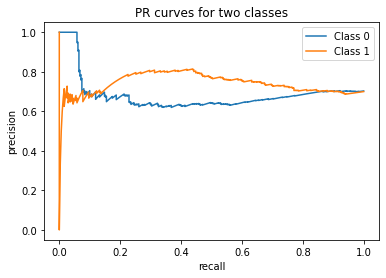

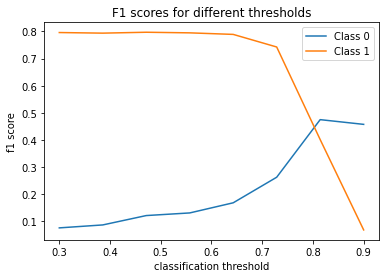

 33%|███▎      | 1/3 [00:02<00:05,  2.74s/it]

{'Class 0': '0.68', 'Class 1': '0.74'}
  Threshold   Class 0   Class 1
0     0.300  0.075000  0.796143
1     0.386  0.085890  0.793914
2     0.471  0.120482  0.797222
3     0.557  0.130178  0.794979
4     0.643  0.167598  0.789250
5     0.729  0.262009  0.742770
6     0.814  0.474576  0.400966
7     0.900  0.457143  0.067485
  Threshold Confusion matrix for train        Confusion matrix
0     0.300      [[40, 240], [5, 835]]   [[6, 127], [21, 289]]
1     0.386     [[44, 236], [10, 830]]   [[7, 126], [23, 287]]
2     0.471     [[48, 232], [13, 827]]  [[10, 123], [23, 287]]
3     0.557     [[60, 220], [19, 821]]  [[11, 122], [25, 285]]
4     0.643     [[85, 195], [34, 806]]  [[15, 118], [31, 279]]
5     0.729    [[150, 130], [88, 752]]  [[30, 103], [66, 244]]
6     0.814    [[258, 22], [518, 322]]  [[112, 21], [227, 83]]
7     0.900      [[278, 2], [762, 78]]   [[128, 5], [299, 11]]


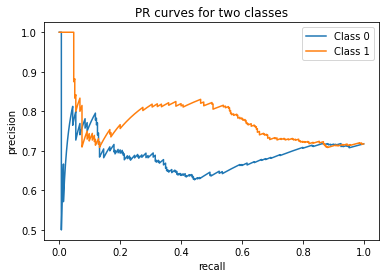

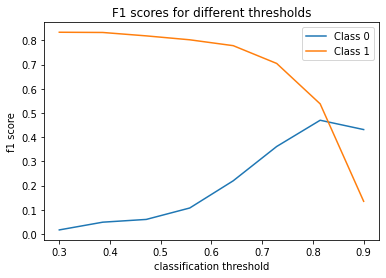

 67%|██████▋   | 2/3 [00:05<00:02,  2.74s/it]

{'Class 0': '0.69', 'Class 1': '0.78'}
  Threshold   Class 0   Class 1
0     0.300  0.016807  0.833570
1     0.386  0.048780  0.832618
2     0.471  0.060150  0.818578
3     0.557  0.107383  0.802377
4     0.643  0.219780  0.778125
5     0.729  0.361538  0.704626
6     0.814  0.469974  0.537585
7     0.900  0.431452  0.134969
  Threshold Confusion matrix for train        Confusion matrix
0     0.300      [[32, 265], [8, 847]]    [[1, 115], [2, 293]]
1     0.386     [[43, 254], [11, 844]]    [[3, 113], [4, 291]]
2     0.471     [[62, 235], [17, 838]]   [[4, 112], [13, 282]]
3     0.557     [[86, 211], [38, 817]]   [[8, 108], [25, 270]]
4     0.643    [[131, 166], [71, 784]]   [[20, 96], [46, 249]]
5     0.729    [[199, 98], [154, 701]]   [[47, 69], [97, 198]]
6     0.814    [[267, 30], [453, 402]]  [[90, 26], [177, 118]]
7     0.900     [[293, 4], [749, 106]]   [[107, 9], [273, 22]]


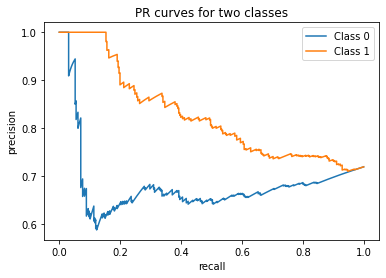

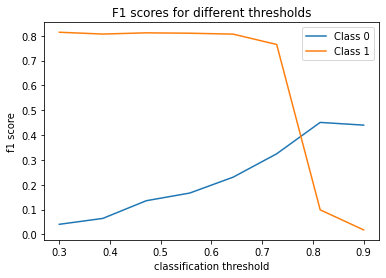

100%|██████████| 3/3 [00:08<00:00,  2.72s/it]

{'Class 0': '0.68', 'Class 1': '0.83'}
  Threshold   Class 0   Class 1
0     0.300  0.040816  0.814229
1     0.386  0.064516  0.806924
2     0.471  0.135802  0.811828
3     0.557  0.166667  0.810298
4     0.643  0.230769  0.806630
5     0.729  0.324786  0.764881
6     0.814  0.451155  0.099125
7     0.900  0.440208  0.018237
  Threshold Confusion matrix for train        Confusion matrix
0     0.300     [[29, 257], [13, 811]]   [[3, 124], [17, 309]]
1     0.386     [[36, 250], [17, 807]]   [[5, 122], [23, 303]]
2     0.471     [[44, 242], [24, 800]]  [[11, 116], [24, 302]]
3     0.557     [[60, 226], [30, 794]]  [[14, 113], [27, 299]]
4     0.643     [[76, 210], [44, 780]]  [[21, 106], [34, 292]]
5     0.729    [[117, 169], [74, 750]]   [[38, 89], [69, 257]]
6     0.814      [[285, 1], [744, 80]]   [[127, 0], [309, 17]]
7     0.900       [[286, 0], [819, 5]]    [[127, 0], [323, 3]]
Average best F1 for class 0:  0.31611117331641353
Average best F1 for class 1:  0.737425818109409


In [361]:
models_svc, best_f1_0_list_svc, best_f1_1_list_svc = svc(X_train_list, X_test_list, y_train_list, y_test_list, j=5)

  0%|          | 0/3 [00:00<?, ?it/s]

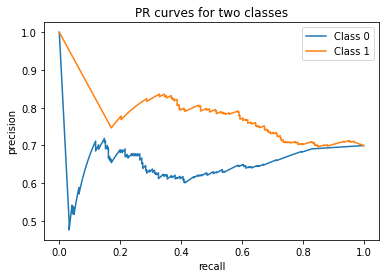

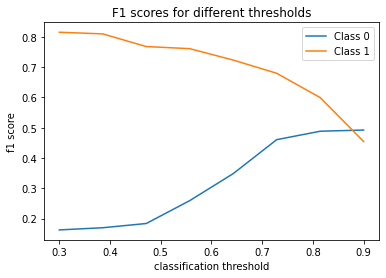

 33%|███▎      | 1/3 [00:01<00:02,  1.22s/it]

{'Class 0': '0.66', 'Class 1': '0.78'}
  Threshold   Class 0   Class 1
0     0.300  0.162500  0.815427
1     0.386  0.169697  0.809986
2     0.471  0.183673  0.768116
3     0.557  0.259259  0.761194
4     0.643  0.348485  0.723473
5     0.729  0.460606  0.679856
6     0.814  0.488432  0.599598
7     0.900  0.492375  0.454333
  Threshold Confusion matrix for train        Confusion matrix
0     0.300      [[33, 247], [4, 836]]  [[13, 120], [14, 296]]
1     0.386     [[51, 229], [17, 823]]  [[14, 119], [18, 292]]
2     0.471     [[84, 196], [39, 801]]  [[18, 115], [45, 265]]
3     0.557    [[127, 153], [70, 770]]  [[28, 105], [55, 255]]
4     0.643   [[175, 105], [118, 722]]   [[46, 87], [85, 225]]
5     0.729    [[210, 70], [203, 637]]  [[76, 57], [121, 189]]
6     0.814    [[241, 39], [354, 486]]  [[95, 38], [161, 149]]
7     0.900    [[258, 22], [506, 334]]  [[113, 20], [213, 97]]


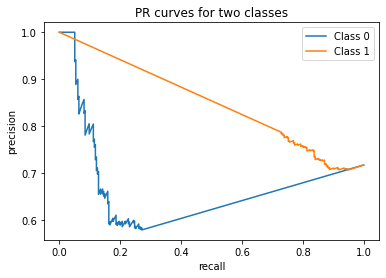

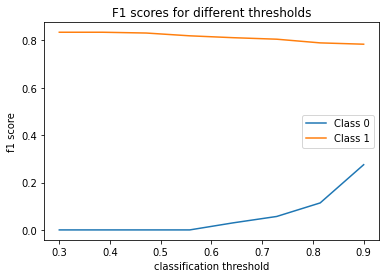

 67%|██████▋   | 2/3 [00:02<00:01,  1.19s/it]

{'Class 0': '0.67', 'Class 1': '0.85'}
  Threshold   Class 0   Class 1
0     0.300  0.000000  0.834043
1     0.386  0.000000  0.834043
2     0.471  0.000000  0.830725
3     0.557  0.000000  0.818966
4     0.643  0.029851  0.811047
5     0.729  0.056738  0.804699
6     0.814  0.113924  0.789157
7     0.900  0.275132  0.783570
  Threshold Confusion matrix for train       Confusion matrix
0     0.300      [[25, 272], [1, 854]]   [[0, 116], [1, 294]]
1     0.386      [[28, 269], [2, 853]]   [[0, 116], [1, 294]]
2     0.471      [[33, 264], [4, 851]]   [[0, 116], [3, 292]]
3     0.557      [[43, 254], [9, 846]]  [[0, 116], [10, 285]]
4     0.643     [[50, 247], [14, 841]]  [[2, 114], [16, 279]]
5     0.729     [[72, 225], [21, 834]]  [[4, 112], [21, 274]]
6     0.814    [[108, 189], [42, 813]]  [[9, 107], [33, 262]]
7     0.900    [[149, 148], [69, 786]]  [[26, 90], [47, 248]]


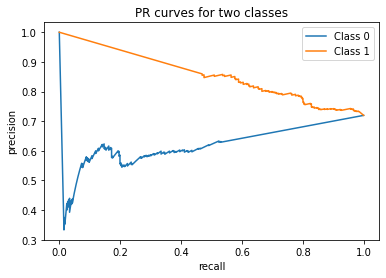

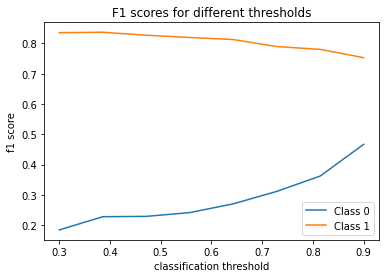

100%|██████████| 3/3 [00:03<00:00,  1.20s/it]

{'Class 0': '0.62', 'Class 1': '0.86'}
  Threshold   Class 0   Class 1
0     0.300  0.184211  0.835544
1     0.386  0.227848  0.836898
2     0.471  0.228916  0.827027
3     0.557  0.241379  0.819672
4     0.643  0.270270  0.812760
5     0.729  0.311321  0.789625
6     0.814  0.362069  0.780415
7     0.900  0.466899  0.752827
  Threshold Confusion matrix for train        Confusion matrix
0     0.300      [[24, 262], [3, 821]]  [[14, 113], [11, 315]]
1     0.386      [[32, 254], [4, 820]]  [[18, 109], [13, 313]]
2     0.471      [[44, 242], [4, 820]]  [[19, 108], [20, 306]]
3     0.557      [[50, 236], [7, 817]]  [[21, 106], [26, 300]]
4     0.643     [[69, 217], [17, 807]]  [[25, 102], [33, 293]]
5     0.729    [[106, 180], [29, 795]]   [[33, 94], [52, 274]]
6     0.814    [[142, 144], [53, 771]]   [[42, 85], [63, 263]]
7     0.900    [[190, 96], [136, 688]]   [[67, 60], [93, 233]]
Average best F1 for class 0:  0.40087909681405615
Average best F1 for class 1:  0.7387511852717216


In [362]:
models_sgd, best_f1_0_list_sgd, best_f1_1_list_sgd = sgd(X_train_list, X_test_list, y_train_list, y_test_list, j=5)

  0%|          | 0/3 [00:00<?, ?it/s]Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


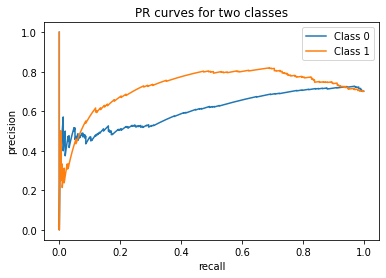

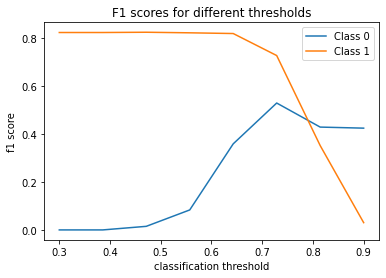

 33%|███▎      | 1/3 [00:28<00:56, 28.14s/it]

{'Class 0': '0.61', 'Class 1': '0.72'}
  Threshold   Class 0   Class 1
0     0.300  0.000000  0.823373
1     0.386  0.000000  0.823373
2     0.471  0.014925  0.824468
3     0.557  0.083333  0.822102
4     0.643  0.358974  0.819103
5     0.729  0.529231  0.727273
6     0.814  0.428875  0.351807
7     0.900  0.424460  0.030303
  Threshold Confusion matrix for train        Confusion matrix
0     0.300      [[89, 191], [0, 840]]    [[0, 133], [0, 310]]
1     0.386     [[157, 123], [0, 840]]    [[0, 133], [0, 310]]
2     0.471      [[219, 61], [0, 840]]    [[1, 132], [0, 310]]
3     0.557      [[252, 28], [0, 840]]    [[6, 127], [5, 305]]
4     0.643      [[270, 10], [0, 840]]   [[35, 98], [27, 283]]
5     0.729      [[280, 0], [13, 827]]  [[86, 47], [106, 204]]
6     0.814     [[280, 0], [126, 714]]  [[101, 32], [237, 73]]
7     0.900     [[280, 0], [495, 345]]   [[118, 15], [305, 5]]


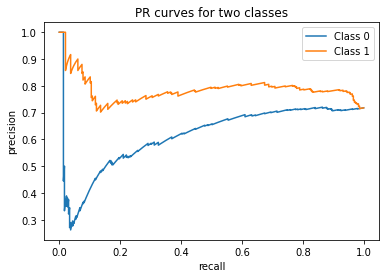

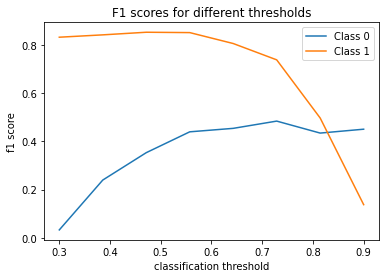

 67%|██████▋   | 2/3 [00:56<00:28, 28.50s/it]

{'Class 0': '0.62', 'Class 1': '0.79'}
  Threshold   Class 0   Class 1
0     0.300  0.032787  0.831429
1     0.386  0.239437  0.841176
2     0.471  0.352941  0.852018
3     0.557  0.439306  0.850539
4     0.643  0.453704  0.805281
5     0.729  0.483755  0.737615
6     0.814  0.434109  0.496552
7     0.900  0.450199  0.137500
  Threshold Confusion matrix for train        Confusion matrix
0     0.300      [[198, 99], [0, 855]]    [[2, 114], [4, 291]]
1     0.386      [[248, 49], [0, 855]]    [[17, 99], [9, 286]]
2     0.471      [[274, 23], [0, 855]]   [[27, 89], [10, 285]]
3     0.557      [[285, 12], [0, 855]]   [[38, 78], [19, 276]]
4     0.643       [[295, 2], [0, 855]]   [[49, 67], [51, 244]]
5     0.729       [[297, 0], [9, 846]]   [[67, 49], [94, 201]]
6     0.814      [[297, 0], [52, 803]]  [[84, 32], [187, 108]]
7     0.900     [[297, 0], [303, 552]]   [[113, 3], [273, 22]]


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


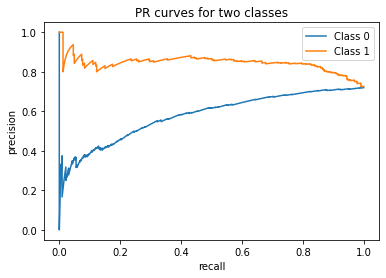

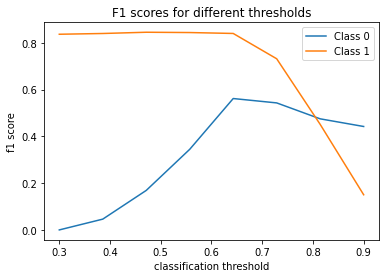

100%|██████████| 3/3 [01:24<00:00, 28.06s/it]

{'Class 0': '0.58', 'Class 1': '0.84'}
  Threshold   Class 0   Class 1
0     0.300  0.000000  0.836970
1     0.386  0.046154  0.840206
2     0.471  0.169014  0.845550
3     0.557  0.344828  0.844262
4     0.643  0.561983  0.840361
5     0.729  0.543284  0.732049
6     0.814  0.475162  0.451467
7     0.900  0.442413  0.150418
  Threshold Confusion matrix for train         Confusion matrix
0     0.300     [[184, 102], [0, 824]]     [[0, 127], [0, 326]]
1     0.386      [[236, 50], [0, 824]]     [[3, 124], [0, 326]]
2     0.471      [[259, 27], [0, 824]]    [[12, 115], [3, 323]]
3     0.557      [[276, 10], [0, 824]]    [[30, 97], [17, 309]]
4     0.643       [[285, 1], [1, 823]]    [[68, 59], [47, 279]]
5     0.729       [[285, 1], [3, 821]]   [[91, 36], [117, 209]]
6     0.814      [[286, 0], [27, 797]]  [[110, 17], [226, 100]]
7     0.900     [[286, 0], [283, 541]]    [[121, 6], [299, 27]]
Average best F1 for class 0:  0.5101735328955508
Average best F1 for class 1:  0.8060578214243724

In [363]:
models_rfc, best_f1_0_list_rfc, best_f1_1_list_rfc = rfc(X_train_list, X_test_list, y_train_list, y_test_list, j=5)


  0%|          | 0/3 [00:00<?, ?it/s]Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


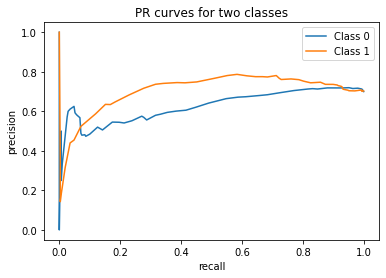

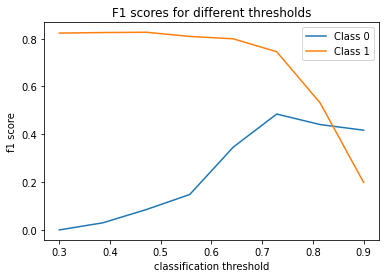

 33%|███▎      | 1/3 [00:01<00:03,  1.63s/it]

{'Class 0': '0.63', 'Class 1': '0.70'}
  Threshold   Class 0   Class 1
0     0.300  0.000000  0.823373
1     0.386  0.029630  0.825566
2     0.471  0.085106  0.826846
3     0.557  0.148148  0.809392
4     0.643  0.346154  0.799410
5     0.729  0.484642  0.745363
6     0.814  0.440594  0.531120
7     0.900  0.417154  0.198391
  Threshold Confusion matrix for train        Confusion matrix
0     0.300      [[267, 13], [0, 840]]    [[0, 133], [0, 310]]
1     0.386       [[280, 0], [0, 840]]    [[2, 131], [0, 310]]
2     0.471       [[280, 0], [0, 840]]    [[6, 127], [2, 308]]
3     0.557       [[280, 0], [0, 840]]  [[12, 121], [17, 293]]
4     0.643       [[280, 0], [0, 840]]   [[36, 97], [39, 271]]
5     0.729       [[280, 0], [0, 840]]   [[71, 62], [89, 221]]
6     0.814       [[280, 0], [3, 837]]  [[89, 44], [182, 128]]
7     0.900      [[280, 0], [93, 747]]  [[107, 26], [273, 37]]


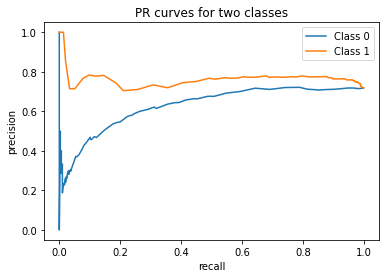

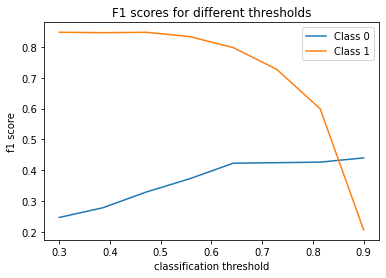

 67%|██████▋   | 2/3 [00:03<00:01,  1.65s/it]

{'Class 0': '0.63', 'Class 1': '0.76'}
  Threshold   Class 0   Class 1
0     0.300  0.246377  0.847953
1     0.386  0.277778  0.846608
2     0.471  0.328947  0.847761
3     0.557  0.372093  0.833846
4     0.643  0.422535  0.798030
5     0.729  0.424242  0.727599
6     0.814  0.426036  0.599174
7     0.900  0.439834  0.205882
  Threshold Confusion matrix for train        Confusion matrix
0     0.300      [[284, 13], [0, 855]]    [[17, 99], [5, 290]]
1     0.386       [[296, 1], [0, 855]]    [[20, 96], [8, 287]]
2     0.471       [[297, 0], [0, 855]]   [[25, 91], [11, 284]]
3     0.557       [[297, 0], [0, 855]]   [[32, 84], [24, 271]]
4     0.643       [[297, 0], [0, 855]]   [[45, 71], [52, 243]]
5     0.729       [[297, 0], [0, 855]]   [[56, 60], [92, 203]]
6     0.814       [[297, 0], [5, 850]]  [[72, 44], [150, 145]]
7     0.900      [[297, 0], [95, 760]]  [[106, 10], [260, 35]]


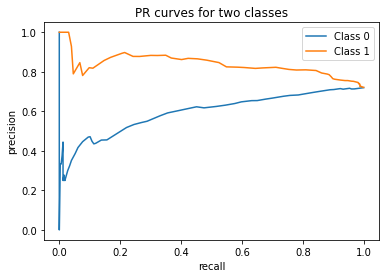

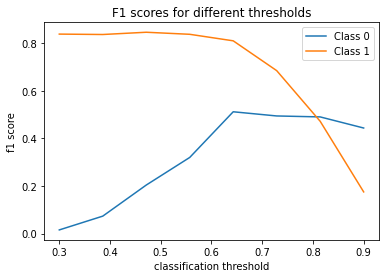

100%|██████████| 3/3 [00:04<00:00,  1.64s/it]

{'Class 0': '0.60', 'Class 1': '0.84'}
  Threshold   Class 0   Class 1
0     0.300  0.015625  0.838046
1     0.386  0.073529  0.836364
2     0.471  0.204082  0.845850
3     0.557  0.320000  0.837209
4     0.643  0.511811  0.809816
5     0.729  0.494253  0.684588
6     0.814  0.490239  0.471910
7     0.900  0.443623  0.175342
  Threshold Confusion matrix for train         Confusion matrix
0     0.300       [[277, 9], [0, 824]]     [[1, 126], [0, 326]]
1     0.386       [[285, 1], [0, 824]]     [[5, 122], [4, 322]]
2     0.471       [[286, 0], [0, 824]]    [[15, 112], [5, 321]]
3     0.557       [[286, 0], [0, 824]]    [[28, 99], [20, 306]]
4     0.643       [[286, 0], [1, 823]]    [[65, 62], [62, 264]]
5     0.729       [[286, 0], [1, 823]]   [[86, 41], [135, 191]]
6     0.814       [[286, 0], [6, 818]]  [[113, 14], [221, 105]]
7     0.900      [[286, 0], [94, 730]]    [[120, 7], [294, 32]]
Average best F1 for class 0:  0.4729959577049696
Average best F1 for class 1:  0.7844026902694218

In [364]:
models_rfc2, best_f1_0_list_rfc2, best_f1_1_list_rfc2 = rfc2(X_train_list, X_test_list, y_train_list, y_test_list, j=5)

  0%|          | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] bagging

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


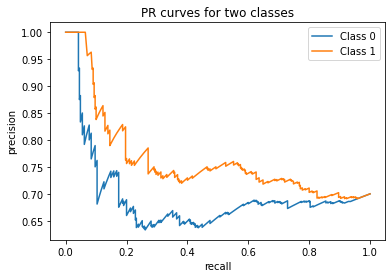

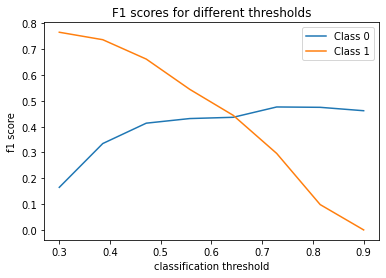

 33%|███▎      | 1/3 [00:06<00:12,  6.19s/it]

Precision recall AUC {'Class 0': '0.70', 'Class 1': '0.76'}
F1   Threshold   Class 0   Class 1
0     0.300  0.164948  0.765896
1     0.386  0.334661  0.737008
2     0.471  0.413580  0.661922
3     0.557  0.431472  0.544715
4     0.643  0.436364  0.443946
5     0.729  0.476378  0.296296
6     0.814  0.475000  0.098160
7     0.900  0.461806  0.000000
Confusion matrix   Threshold Confusion matrix for train        Confusion matrix
0     0.300    [[121, 159], [56, 784]]  [[16, 117], [45, 265]]
1     0.386   [[172, 108], [129, 711]]   [[42, 91], [76, 234]]
2     0.471    [[202, 78], [199, 641]]  [[67, 66], [124, 186]]
3     0.557    [[233, 47], [283, 557]]  [[85, 48], [176, 134]]
4     0.643    [[253, 27], [372, 468]]   [[96, 37], [211, 99]]
5     0.729    [[264, 16], [521, 319]]  [[121, 12], [254, 56]]
6     0.814     [[276, 4], [713, 127]]   [[133, 0], [294, 16]]
7     0.900       [[279, 1], [833, 7]]    [[133, 0], [310, 0]]
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


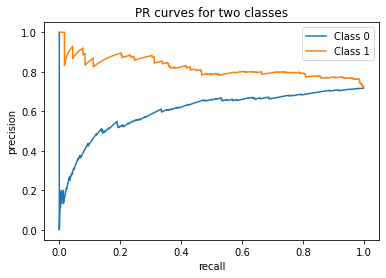

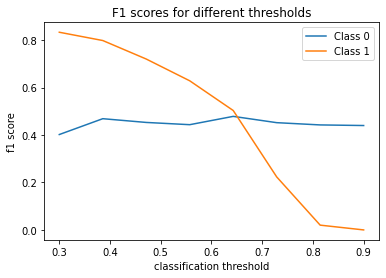

 67%|██████▋   | 2/3 [00:11<00:05,  5.68s/it]

Precision recall AUC {'Class 0': '0.60', 'Class 1': '0.82'}
F1   Threshold   Class 0   Class 1
0     0.300  0.402235  0.833593
1     0.386  0.469027  0.798658
2     0.471  0.453237  0.720588
3     0.557  0.443769  0.628803
4     0.643  0.478803  0.503563
5     0.729  0.452282  0.223529
6     0.814  0.442748  0.020134
7     0.900  0.440228  0.000000
Confusion matrix   Threshold Confusion matrix for train        Confusion matrix
0     0.300     [[84, 213], [47, 808]]   [[36, 80], [27, 268]]
1     0.386   [[162, 135], [121, 734]]   [[53, 63], [57, 238]]
2     0.471    [[223, 74], [224, 631]]   [[63, 53], [99, 196]]
3     0.557    [[249, 48], [316, 539]]  [[73, 43], [140, 155]]
4     0.643    [[261, 36], [451, 404]]  [[96, 20], [189, 106]]
5     0.729    [[282, 15], [626, 229]]   [[109, 7], [257, 38]]
6     0.814      [[296, 1], [781, 74]]    [[116, 0], [292, 3]]
7     0.900       [[297, 0], [854, 1]]    [[116, 0], [295, 0]]
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


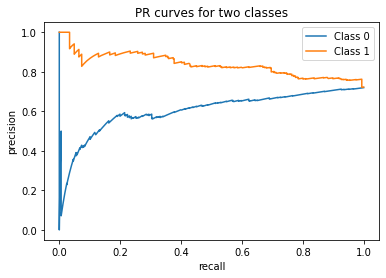

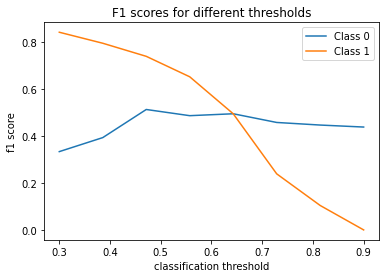

100%|██████████| 3/3 [00:16<00:00,  5.65s/it]

Precision recall AUC {'Class 0': '0.60', 'Class 1': '0.84'}
F1   Threshold   Class 0   Class 1
0     0.300  0.333333  0.841530
1     0.386  0.393013  0.794682
2     0.471  0.512658  0.738983
3     0.557  0.486339  0.651852
4     0.643  0.494481  0.494481
5     0.729  0.457467  0.238727
6     0.814  0.446429  0.104046
7     0.900  0.437931  0.000000
Confusion matrix   Threshold Confusion matrix for train         Confusion matrix
0     0.300     [[66, 220], [46, 778]]    [[29, 98], [18, 308]]
1     0.386   [[144, 142], [102, 722]]    [[45, 82], [57, 269]]
2     0.471    [[201, 85], [208, 616]]   [[81, 46], [108, 218]]
3     0.557    [[236, 50], [320, 504]]   [[89, 38], [150, 176]]
4     0.643    [[263, 23], [464, 360]]  [[112, 15], [214, 112]]
5     0.729     [[281, 5], [653, 171]]    [[121, 6], [281, 45]]
6     0.814      [[284, 2], [747, 77]]    [[125, 2], [308, 18]]
7     0.900       [[286, 0], [824, 0]]     [[127, 0], [326, 0]]
Average best F1 for class 0:  0.4650883411447493
Average

In [365]:
models_xgb, best_f1_0_list_xgb, best_f1_1_list_xgb = xgboost(X_train_list, X_test_list, y_train_list, y_test_list, j=5)

  0%|          | 0/3 [00:00<?, ?it/s]

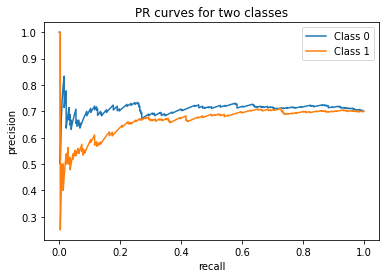

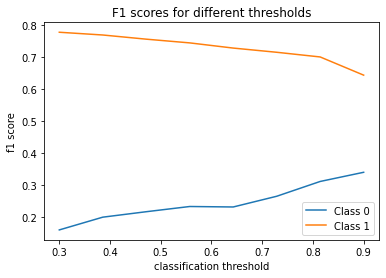

 33%|███▎      | 1/3 [00:02<00:04,  2.18s/it]

Precision recall AUC {'Class 0': '0.71', 'Class 1': '0.66'}
F1   Threshold   Class 0   Class 1
0     0.300  0.161290  0.777143
1     0.386  0.201005  0.768559
2     0.471  0.218009  0.755556
3     0.557  0.234234  0.743976
4     0.643  0.232759  0.727829
5     0.729  0.266129  0.714734
6     0.814  0.312268  0.700162
7     0.900  0.340836  0.643478
Confusion matrix   Threshold Confusion matrix for train        Confusion matrix
0     0.300       [[280, 0], [0, 840]]  [[15, 118], [38, 272]]
1     0.386       [[280, 0], [0, 840]]  [[20, 113], [46, 264]]
2     0.471       [[280, 0], [0, 840]]  [[23, 110], [55, 255]]
3     0.557       [[280, 0], [0, 840]]  [[26, 107], [63, 247]]
4     0.643       [[280, 0], [0, 840]]  [[27, 106], [72, 238]]
5     0.729       [[280, 0], [0, 840]]  [[33, 100], [82, 228]]
6     0.814       [[280, 0], [0, 840]]   [[42, 91], [94, 216]]
7     0.900       [[280, 0], [0, 840]]  [[53, 80], [125, 185]]


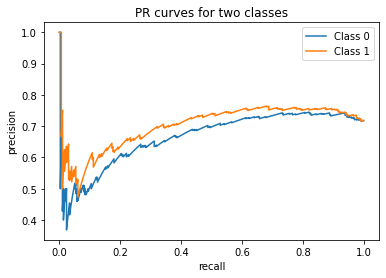

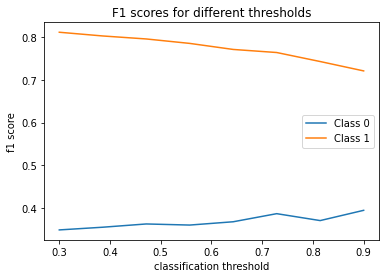

 67%|██████▋   | 2/3 [00:04<00:02,  2.26s/it]

Precision recall AUC {'Class 0': '0.67', 'Class 1': '0.70'}
F1   Threshold   Class 0   Class 1
0     0.300  0.347826  0.811912
1     0.386  0.354167  0.803175
2     0.471  0.361809  0.796148
3     0.557  0.359223  0.785714
4     0.643  0.366972  0.771523
5     0.729  0.385965  0.764310
6     0.814  0.369748  0.743151
7     0.900  0.393822  0.721137
Confusion matrix   Threshold Confusion matrix for train       Confusion matrix
0     0.300       [[297, 0], [0, 855]]  [[32, 84], [36, 259]]
1     0.386       [[297, 0], [0, 855]]  [[34, 82], [42, 253]]
2     0.471       [[297, 0], [0, 855]]  [[36, 80], [47, 248]]
3     0.557       [[297, 0], [0, 855]]  [[37, 79], [53, 242]]
4     0.643       [[297, 0], [0, 855]]  [[40, 76], [62, 233]]
5     0.729       [[297, 0], [0, 855]]  [[44, 72], [68, 227]]
6     0.814       [[297, 0], [0, 855]]  [[44, 72], [78, 217]]
7     0.900       [[297, 0], [0, 855]]  [[51, 65], [92, 203]]


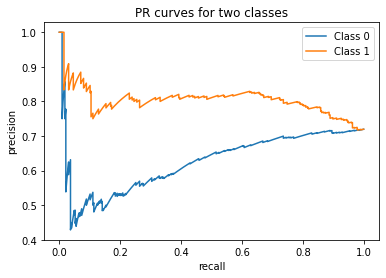

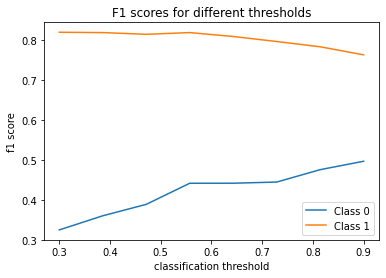

100%|██████████| 3/3 [00:06<00:00,  2.23s/it]

Precision recall AUC {'Class 0': '0.63', 'Class 1': '0.80'}
F1   Threshold   Class 0   Class 1
0     0.300  0.324607  0.819580
1     0.386  0.360000  0.818697
2     0.471  0.388626  0.814388
3     0.557  0.441441  0.818713
4     0.643  0.441558  0.808889
5     0.729  0.444444  0.796380
6     0.814  0.475472  0.783151
7     0.900  0.496552  0.762987
Confusion matrix   Threshold Confusion matrix for train       Confusion matrix
0     0.300       [[286, 0], [0, 824]]  [[31, 96], [33, 293]]
1     0.386       [[286, 0], [0, 824]]  [[36, 91], [37, 289]]
2     0.471       [[286, 0], [0, 824]]  [[41, 86], [43, 283]]
3     0.557       [[286, 0], [0, 824]]  [[49, 78], [46, 280]]
4     0.643       [[286, 0], [0, 824]]  [[51, 76], [53, 273]]
5     0.729       [[286, 0], [0, 824]]  [[54, 73], [62, 264]]
6     0.814       [[286, 0], [0, 824]]  [[63, 64], [75, 251]]
7     0.900       [[286, 0], [0, 824]]  [[72, 55], [91, 235]]
Average best F1 for class 0:  0.4077842164267897
Average best F1 for class

In [366]:
models_xgb2, best_f1_0_list_xgb2, best_f1_1_list_xgb2 = xgboost2(X_train_list, X_test_list, y_train_list, y_test_list, j=5)


## Model interpretation

### Mutual information

In [367]:
# get features by mutual information
mutual_info_feat_list = []
for i in tqdm(range(len(X_train_list))):
    mutual_info_feat = []
    for k in range(5, 100, 5):
        mutual_info_feat.append(mutual_info(X_train_list[i].drop(columns=['Participant ID']), np.array(y_train_list[i].drop(columns=['Participant ID'])).ravel(), k))
    mutual_info_feat_list.append(mutual_info_feat)

100%|██████████| 3/3 [03:18<00:00, 66.32s/it]


In [368]:
for i in range(len(X_train_list)):
    print(list(mutual_info_feat_list[i][3]))

['g__Adlercreutzia', 'g__Slackia', 'g__Bacteroides', 'g__Coprobacter', 'g__Parabacteroides', 'g__Alistipes', 'g__Clostridiales_noname', 'g__Butyrivibrio', 'g__Coprococcus', 'g__Roseburia', 'g__Oscillibacter', 'g__Ruminococcus', 'g__Subdoligranulum', 'g__Coprobacillus', 'g__Oxalobacter', 'g__Sutterella', 'g__Sutterellaceae_unclassified', 'g__Bilophila', 'g__Actinobacillus', 'g__Gammaretrovirus']
['g__Coprobacter', 'g__Dysgonomonas', 'g__Alistipes', 'g__Lactobacillus', 'g__Clostridiales_noname', 'g__Eubacterium', 'g__Dorea', 'g__Oscillibacter', 'g__Ruminococcus', 'g__Subdoligranulum', 'g__Coprobacillus', 'g__Acidaminococcaceae_unclassified', 'g__Acidaminococcus', 'g__Burkholderiales_noname', 'g__Oxalobacter', 'g__Sutterella', 'g__Bilophila', 'g__Akkermansia', 'g__Mulikevirus', 'g__T4likevirus']
['g__Gardnerella', 'g__Olsenella', 'g__Bacteroides', 'g__Coprobacter', 'g__Dysgonomonas', 'g__Alistipes', 'g__Enterococcus', 'g__Pseudoflavonifractor', 'g__Eubacterium', 'g__Oscillibacter', 'g__Ru

In [476]:
mutual_info_feat_list_for_overlap = []
for i in range(len(X_train_list)):
    mutual_info_feat_list_for_overlap.append(list(mutual_info_feat_list[i][3]))

### SGD coefficients

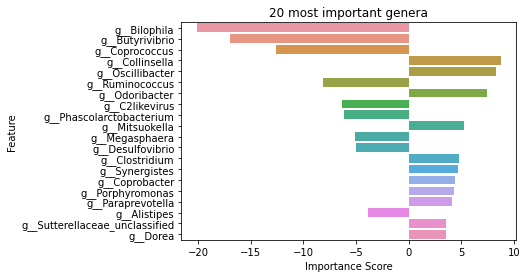

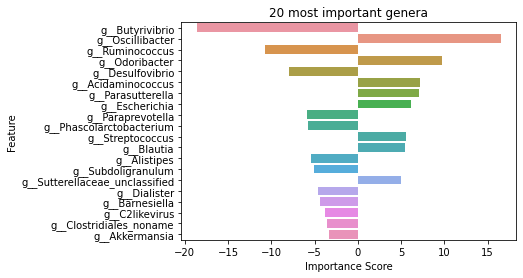

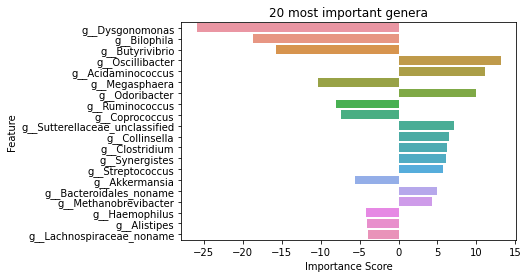

In [455]:
common_sgd_feats = []
for i in range(len(X_train_list)):
    f = linear_feat(X_train_list[i].drop(columns=['Participant ID']),\
                          y_train_list[i].drop(columns=['Participant ID']), models_sgd[i], j=20)
    common_sgd_feats.append(bestklinear(f, 20))

### SVC coefficients

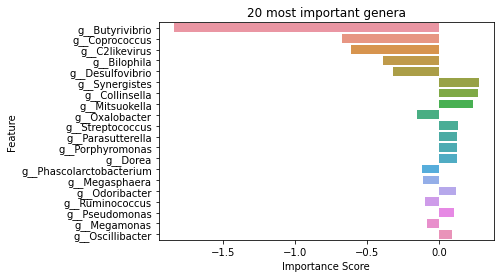

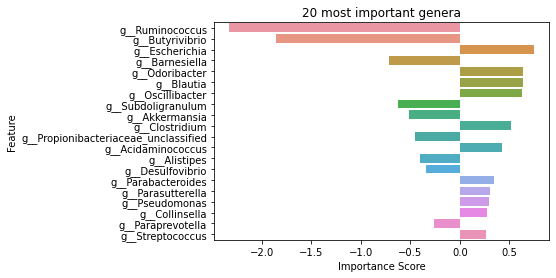

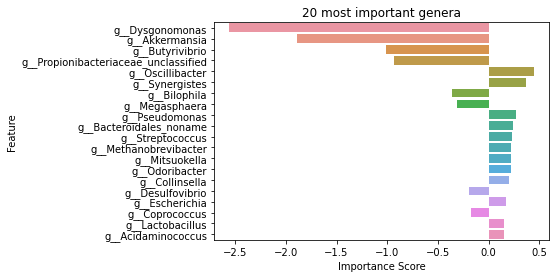

In [478]:
common_svc_feats = []
for i in range(len(X_train_list)):
    f = linear_feat(X_train_list[i].drop(columns=['Participant ID']),\
                          y_train_list[i].drop(columns=['Participant ID']), models_svc[i], j=20)
    common_svc_feats.append(bestklinear(f, 20))

### Gini importance (random forest classifier)

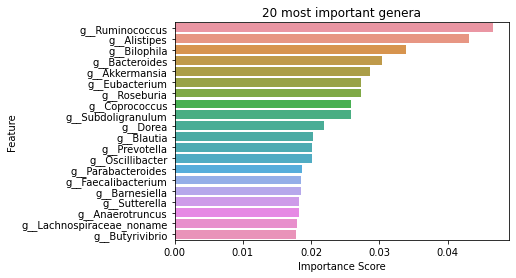

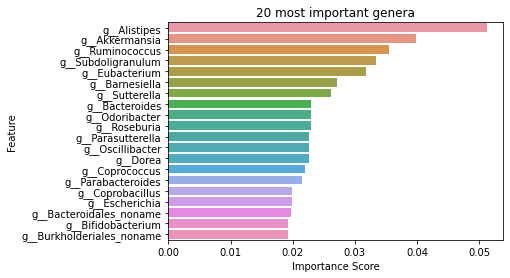

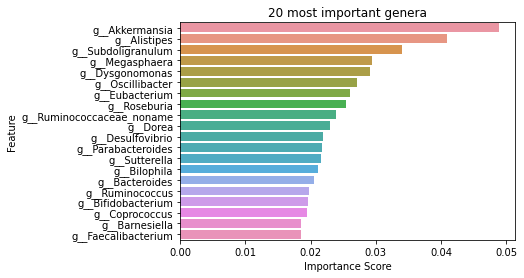

In [479]:
common_rf_feats = []
for i in range(len(X_train_list)):
    f = tree_feat(X_train_list[i].drop(columns=['Participant ID']),\
                          y_train_list[i].drop(columns=['Participant ID']), models_rfc[i], k=20)
    common_rf_feats.append(bestktree(f, 20))

### SHAP importance (random forest classifier)

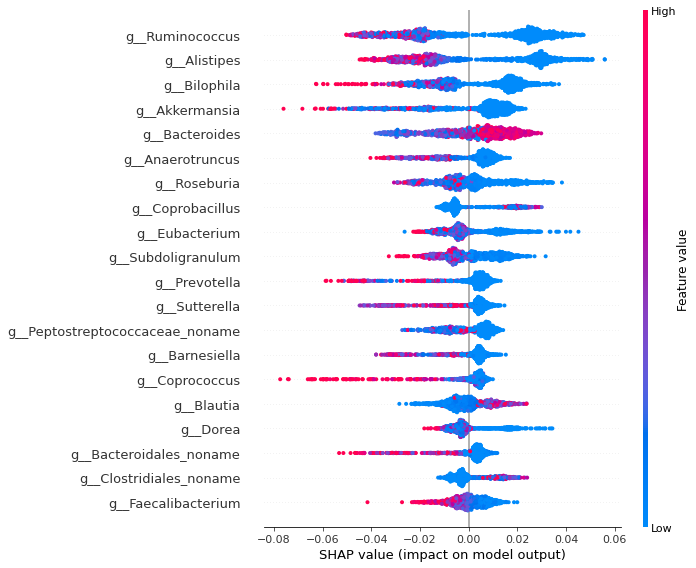

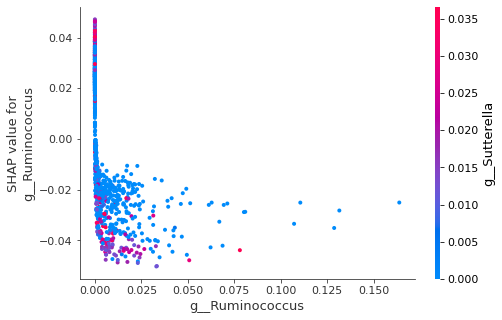

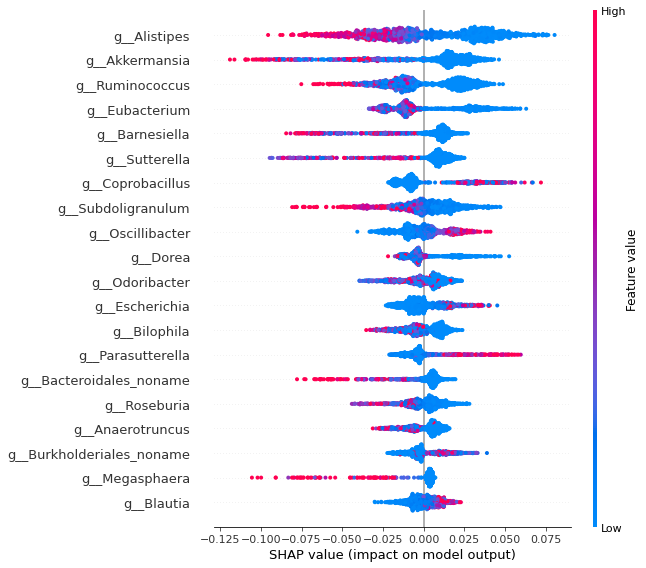

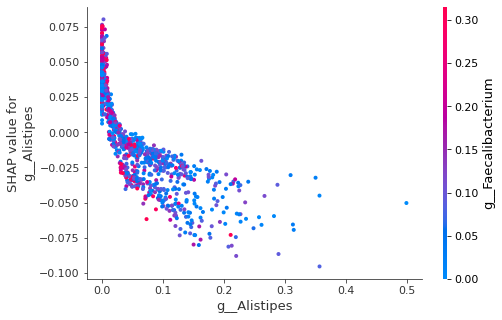

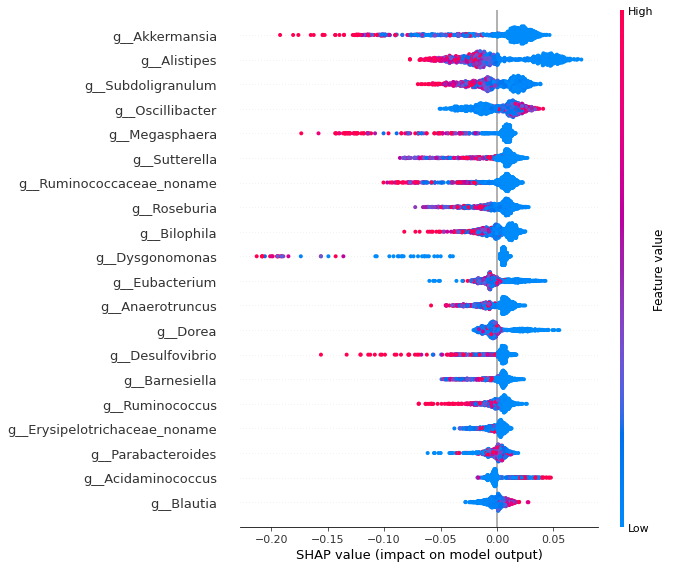

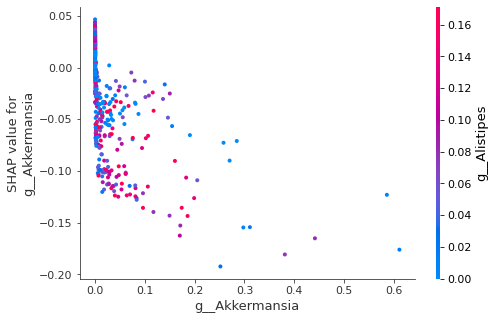

In [481]:
common_rfshap_feats = []
for i in range(len(X_train_list)):
    one_sample_rfc, x = shap_feat(X_train_list[i].drop(columns=['Participant ID']),\
                          y_train_list[i].drop(columns=['Participant ID']), models_rfc[i], j=3)
    common_rfshap_feats.append(bestkshap(X_train_list[i].drop(columns=['Participant ID']), x, 20))

In [373]:
one_sample_rfc

### Default importance (gradient boosting)

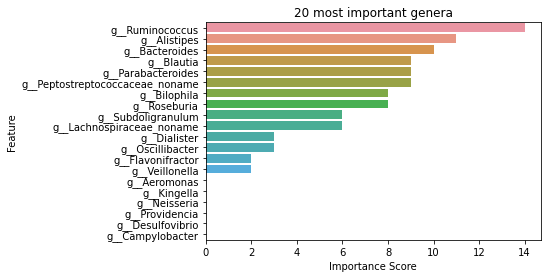

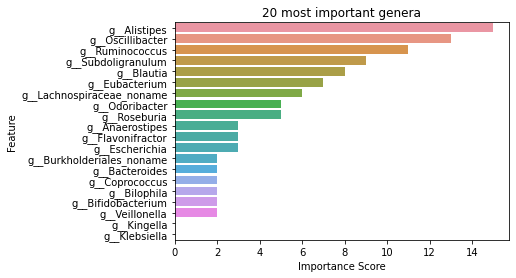

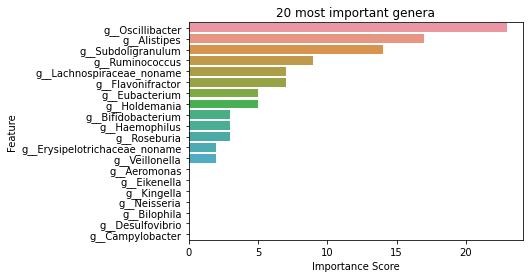

In [483]:
common_xgb_feats = []
for i in range(len(X_train_list)):
    f = tree_feat(X_train_list[i].drop(columns=['Participant ID']),\
                          y_train_list[i].drop(columns=['Participant ID']), models_xgb[i], k=20)
    common_xgb_feats.append(bestktree(f, 20))

### SHAP importance (gradient boosting)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


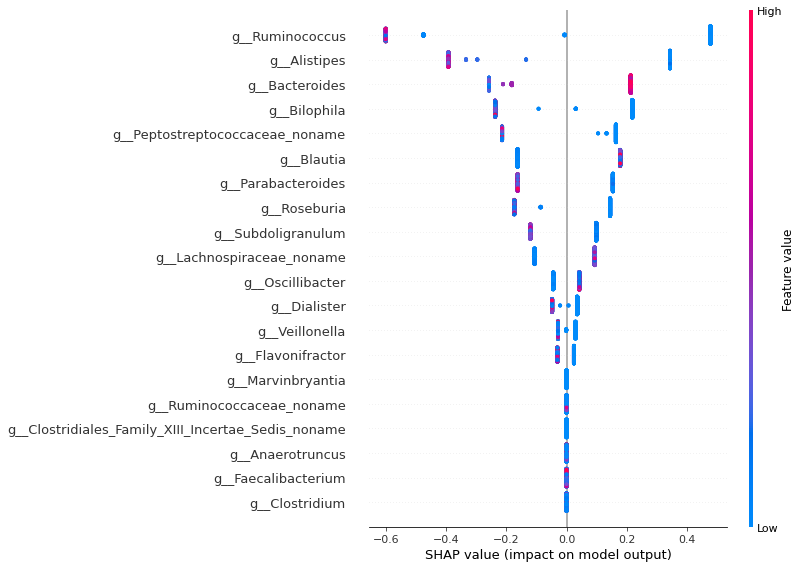

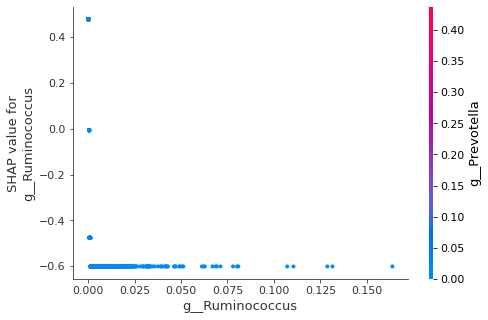

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


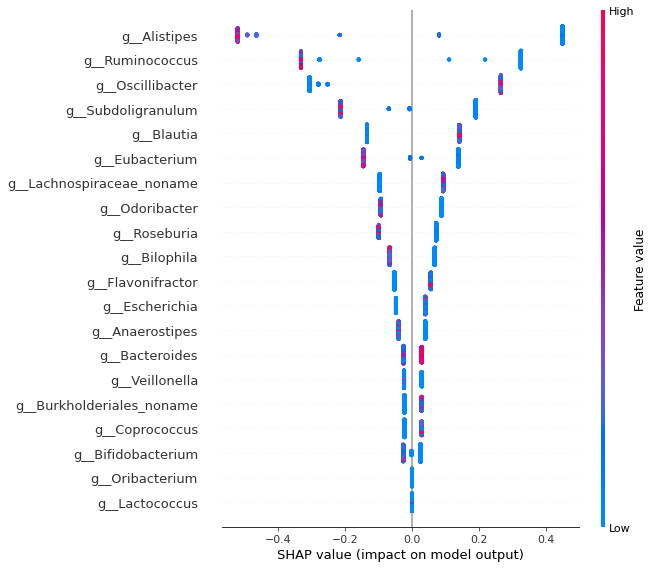

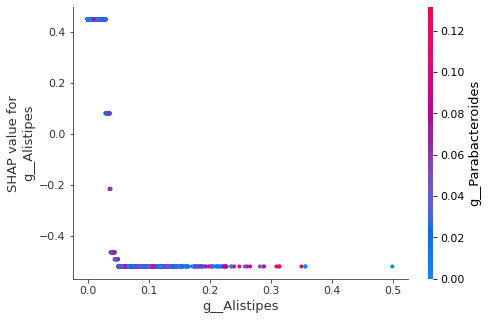

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


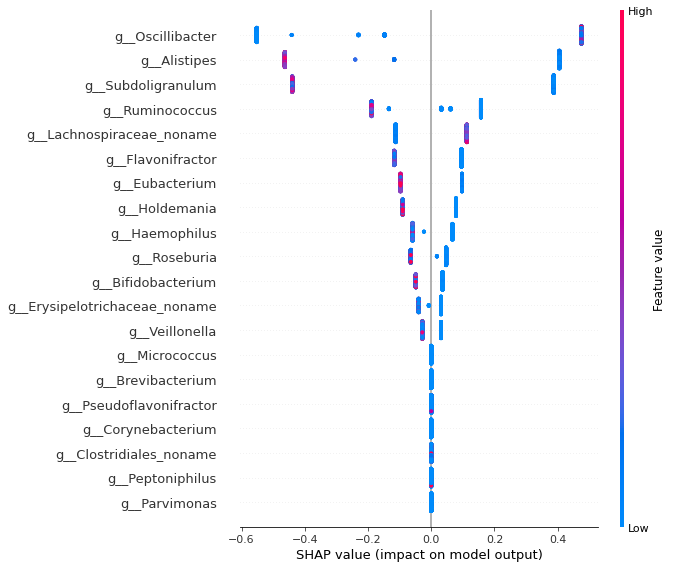

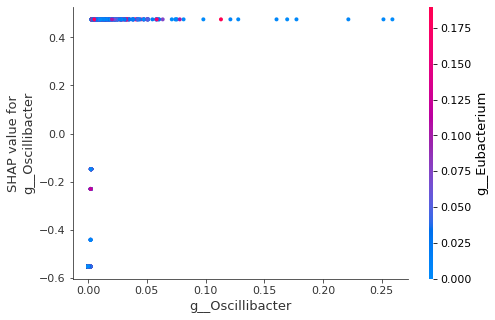

In [487]:
common_xgbshap_feats = []
for i in range(len(X_train_list)):
    one_sample_xgb, s = shap_feat(X_train_list[i].drop(columns=['Participant ID']),\
                          y_train_list[i].drop(columns=['Participant ID']), models_xgb[i], j=3)
    common_xgbshap_feats.append(bestkshap(X_train_list[i].drop(columns=['Participant ID']), s, 20))

In [379]:
one_sample_xgb

In [498]:
common_features_all = []
for each in [mutual_info_feat_list_for_overlap, common_svc_feats, common_sgd_feats, common_rf_feats,\
            common_rfshap_feats, common_xgb_feats, common_xgbshap_feats]:
    common_features_all.append(find_overlap(each)[1])

find_overlap(common_features_all)

({'g__Dorea': 2,
  'g__Blautia': 1,
  'g__Streptococcus': 1,
  'g__Akkermansia': 2,
  'g__Coprobacter': 1,
  'g__Parabacteroides': 1,
  'g__Sutterellaceae_unclassified': 1,
  'g__Flavonifractor': 2,
  'g__Barnesiella': 2,
  'g__Kingella': 1,
  'g__Odoribacter': 2,
  'g__Bacteroides': 1,
  'g__Alistipes': 6,
  'g__Sutterella': 3,
  'g__Ruminococcus': 6,
  'g__Eubacterium': 2,
  'g__Collinsella': 1,
  'g__Anaerotruncus': 1,
  'g__Veillonella': 2,
  'g__Desulfovibrio': 1,
  'g__Subdoligranulum': 5,
  'g__Roseburia': 4,
  'g__Aeromonas': 1,
  'g__Pseudomonas': 1,
  'g__Oscillibacter': 6,
  'g__Lachnospiraceae_noname': 2,
  'g__Bilophila': 2,
  'g__Terriglobus': 1,
  'g__Butyrivibrio': 2,
  'g__Coprococcus': 1},
 ['g__Alistipes', 'g__Ruminococcus', 'g__Oscillibacter'])

## Model performance with selected features

### Train test split

In [378]:
X_train_temp = []
X_test_temp = []
y_train_temp = []
y_test_temp  = []

for i in range(1):
    X_train_, X_test_, y_train_, y_test_, _, _ = patient_split(X_all, y_all)
    X_train_temp.append(X_train_)
    X_test_temp.append(X_test_)
    y_train_temp.append(y_train_)
    y_test_temp.append(y_test_)

In [380]:
print('# IBD people', X_train_temp[0][y_train_temp[0]['diseased']==1].groupby('Participant ID').sum().shape[0])
print('# healthy people', X_train_temp[0][y_train_temp[0]['diseased']==0].groupby('Participant ID').sum().shape[0])
print('# IBD samples', y_train_temp[0][y_train_temp[0]['diseased']==1].shape[0])
print('# healthy samples', y_train_temp[0][y_train_temp[0]['diseased']==0].shape[0])

# IBD people 59
# healthy people 19
# IBD samples 843
# healthy samples 316


In [381]:
print('# IBD people', X_test_temp[0][y_test_temp[0]['diseased']==1].groupby('Participant ID').sum().shape[0])
print('# healthy people', X_test_temp[0][y_test_temp[0]['diseased']==0].groupby('Participant ID').sum().shape[0])
print('# IBD samples', y_test_temp[0][y_test_temp[0]['diseased']==1].shape[0])
print('# healthy samples', y_test_temp[0][y_test_temp[0]['diseased']==0].shape[0])

# IBD people 21
# healthy people 8
# IBD samples 307
# healthy samples 97


### Random forest classifier

  0%|          | 0/1 [00:00<?, ?it/s]

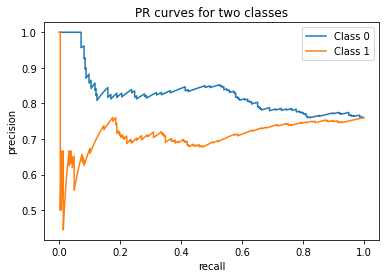

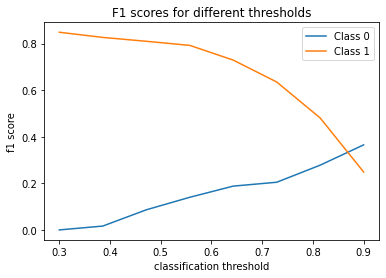

100%|██████████| 1/1 [00:28<00:00, 28.48s/it]

{'Class 0': '0.83', 'Class 1': '0.71'}
  Threshold   Class 0   Class 1
0     0.300  0.000000  0.849003
1     0.386  0.016529  0.826783
2     0.471  0.086331  0.810164
3     0.557  0.140127  0.792627
4     0.643  0.188119  0.729373
5     0.729  0.204724  0.635379
6     0.814  0.278107  0.480851
7     0.900  0.365297  0.248649
  Threshold Confusion matrix for train        Confusion matrix
0     0.300      [[261, 55], [0, 843]]     [[0, 97], [9, 298]]
1     0.386      [[284, 32], [0, 843]]    [[1, 96], [23, 284]]
2     0.471      [[296, 20], [0, 843]]    [[6, 91], [36, 271]]
3     0.557       [[309, 7], [0, 843]]   [[11, 86], [49, 258]]
4     0.643       [[313, 3], [0, 843]]   [[19, 78], [86, 221]]
5     0.729       [[315, 1], [1, 842]]  [[26, 71], [131, 176]]
6     0.814      [[316, 0], [14, 829]]  [[47, 50], [194, 113]]
7     0.900     [[316, 0], [171, 672]]   [[80, 17], [261, 46]]
Average best F1 for class 0:  0.18811881188118812
Average best F1 for class 1:  0.7293729372937293


In [382]:
model_rf, f1_0_rf, f1_1_rf = rfc(X_train_temp, X_test_temp, y_train_temp, y_test_temp, j=5)
model_rf = model_rf[0]
f1_0_rf = f1_0_rf[0]
f1_1_rf = f1_1_rf[0]

### Gradient boosting classifier

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
[LightGBM] [Warning] bagging

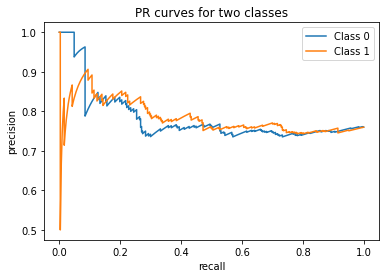

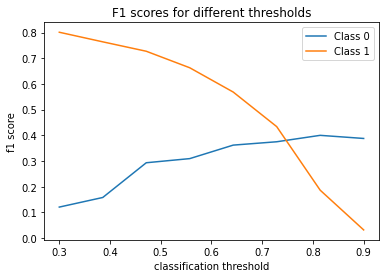

100%|██████████| 1/1 [00:04<00:00,  4.67s/it]

Precision recall AUC {'Class 0': '0.78', 'Class 1': '0.78'}
F1   Threshold   Class 0   Class 1
0     0.300  0.120805  0.801214
1     0.386  0.158192  0.763867
2     0.471  0.293333  0.727273
3     0.557  0.309434  0.662983
4     0.643  0.361963  0.568465
5     0.729  0.375000  0.433962
6     0.814  0.400000  0.186589
7     0.900  0.387879  0.031949
Confusion matrix   Threshold Confusion matrix for train        Confusion matrix
0     0.300    [[145, 171], [39, 804]]    [[9, 88], [43, 264]]
1     0.386   [[196, 120], [103, 740]]   [[14, 83], [66, 241]]
2     0.471    [[238, 78], [188, 655]]   [[33, 64], [95, 212]]
3     0.557    [[262, 54], [273, 570]]  [[41, 56], [127, 180]]
4     0.643    [[287, 29], [379, 464]]  [[59, 38], [170, 137]]
5     0.729    [[302, 14], [507, 336]]   [[72, 25], [215, 92]]
6     0.814     [[313, 3], [675, 168]]    [[93, 4], [275, 32]]
7     0.900      [[314, 2], [819, 24]]     [[96, 1], [302, 5]]
Average best F1 for class 0:  0.29333333333333333
Average best F1

In [383]:
model_xgb, f1_0_xgb, f1_1_xgb = xgboost(X_train_temp, X_test_temp, y_train_temp, y_test_temp, j=5)
model_xgb = model_xgb[0]
f1_0_xgb = f1_0_xgb[0]
f1_1_xgb = f1_1_xgb[0]

### Support vector classifier

  0%|          | 0/1 [00:00<?, ?it/s]

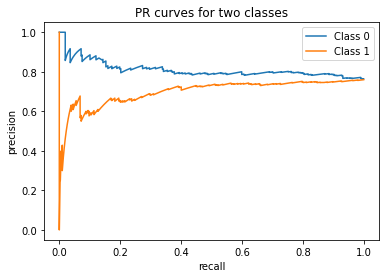

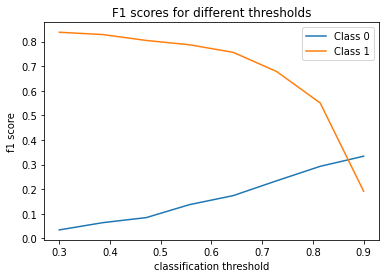

100%|██████████| 1/1 [00:02<00:00,  2.79s/it]

{'Class 0': '0.81', 'Class 1': '0.70'}
  Threshold   Class 0   Class 1
0     0.300  0.034483  0.838150
1     0.386  0.064000  0.828697
2     0.471  0.084507  0.804805
3     0.557  0.137500  0.787037
4     0.643  0.173913  0.756410
5     0.729  0.234310  0.678383
6     0.814  0.292994  0.550607
7     0.900  0.334086  0.191781
  Threshold Confusion matrix for train        Confusion matrix
0     0.300     [[71, 245], [26, 817]]    [[2, 95], [17, 290]]
1     0.386     [[85, 231], [35, 808]]    [[4, 93], [24, 283]]
2     0.471    [[109, 207], [54, 789]]    [[6, 91], [39, 268]]
3     0.557    [[139, 177], [84, 759]]   [[11, 86], [52, 255]]
4     0.643   [[181, 135], [117, 726]]   [[16, 81], [71, 236]]
5     0.729    [[236, 80], [195, 648]]  [[28, 69], [114, 193]]
6     0.814    [[284, 32], [354, 489]]  [[46, 51], [171, 136]]
7     0.900     [[310, 6], [647, 196]]   [[74, 23], [272, 35]]
Average best F1 for class 0:  0.2929936305732484
Average best F1 for class 1:  0.5506072874493927


In [384]:
model_svc, f1_0_svc, f1_1_svc = svc(X_train_temp, X_test_temp, y_train_temp, y_test_temp, j=5)
model_svc = model_svc[0]
f1_0_svc = f1_0_svc[0]
f1_1_svc = f1_1_svc[0]

### Stochastic gradient descent classifier

  0%|          | 0/1 [00:00<?, ?it/s]

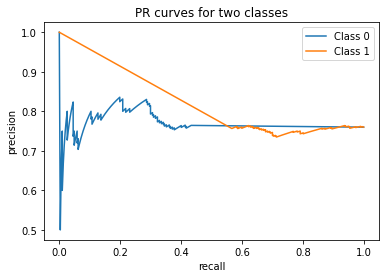

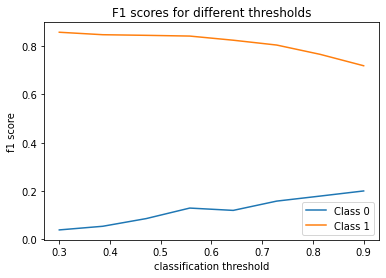

100%|██████████| 1/1 [00:01<00:00,  1.16s/it]

{'Class 0': '0.77', 'Class 1': '0.82'}
  Threshold   Class 0   Class 1
0     0.300  0.038462  0.857955
1     0.386  0.053571  0.847701
2     0.471  0.085470  0.845152
3     0.557  0.129032  0.842105
4     0.643  0.119403  0.824926
5     0.729  0.157895  0.804878
6     0.814  0.178771  0.766296
7     0.900  0.200000  0.719064
  Threshold Confusion matrix for train       Confusion matrix
0     0.300      [[39, 277], [3, 840]]    [[2, 95], [5, 302]]
1     0.386      [[49, 267], [6, 837]]   [[3, 94], [12, 295]]
2     0.471      [[60, 256], [9, 834]]   [[5, 92], [15, 292]]
3     0.557     [[72, 244], [17, 826]]   [[8, 89], [19, 288]]
4     0.643    [[106, 210], [31, 812]]   [[8, 89], [29, 278]]
5     0.729    [[155, 161], [47, 796]]  [[12, 85], [43, 264]]
6     0.814    [[195, 121], [88, 755]]  [[16, 81], [66, 241]]
7     0.900    [[253, 63], [153, 690]]  [[21, 76], [92, 215]]
Average best F1 for class 0:  0.2
Average best F1 for class 1:  0.7190635451505017


In [385]:
model_sgd, f1_0_sgd, f1_1_sgd = sgd(X_train_temp, X_test_temp, y_train_temp, y_test_temp, j=5)
model_sgd = model_sgd[0]
f1_0_sgd = f1_0_sgd[0]
f1_1_sgd = f1_1_sgd[0]

### Feature importances

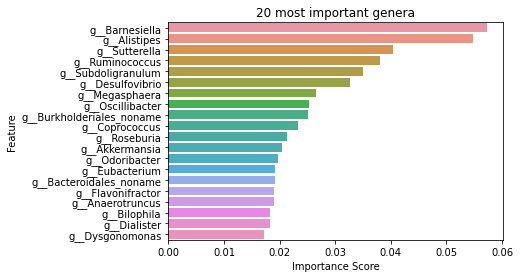

In [386]:
tree_feats_rf = tree_feat(X_train_temp[0].drop(columns=['Participant ID']),\
                          y_train_temp[0].drop(columns=['Participant ID']), model_rf, k=20)

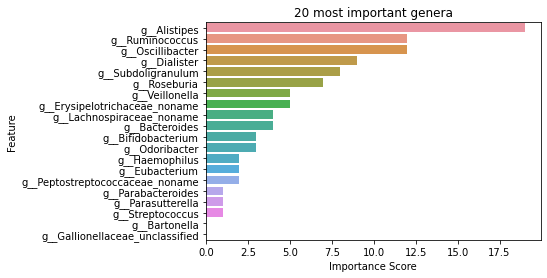

In [387]:
tree_feats_xgb = tree_feat(X_train_temp[0].drop(columns=['Participant ID']),\
                          y_train_temp[0].drop(columns=['Participant ID']), model_xgb, k=20)

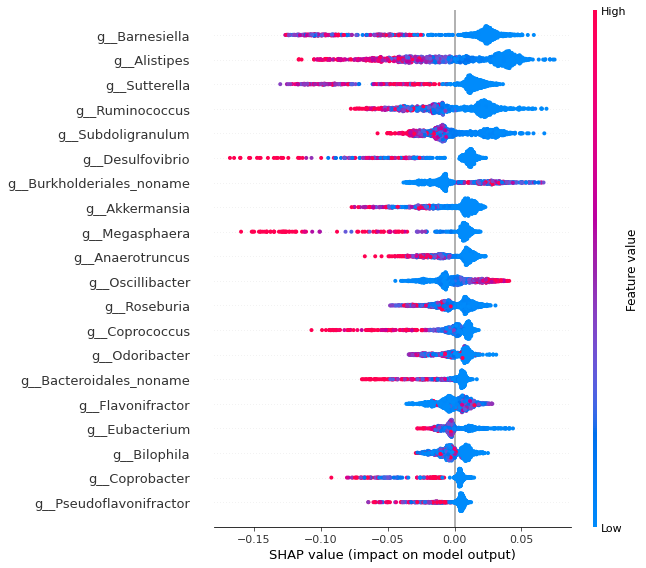

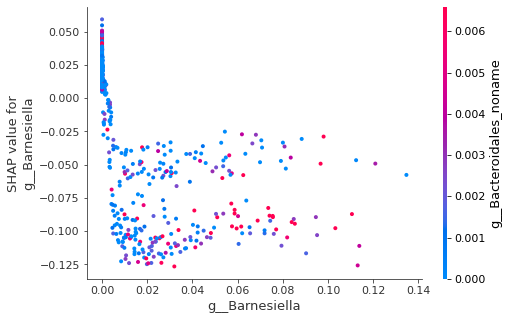

In [388]:
p_rf, shap_feats_rf = shap_feat(X_train_temp[0].drop(columns=['Participant ID']),\
                          y_train_temp[0].drop(columns=['Participant ID']), model_rf, j=3)

In [389]:
p_rf

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


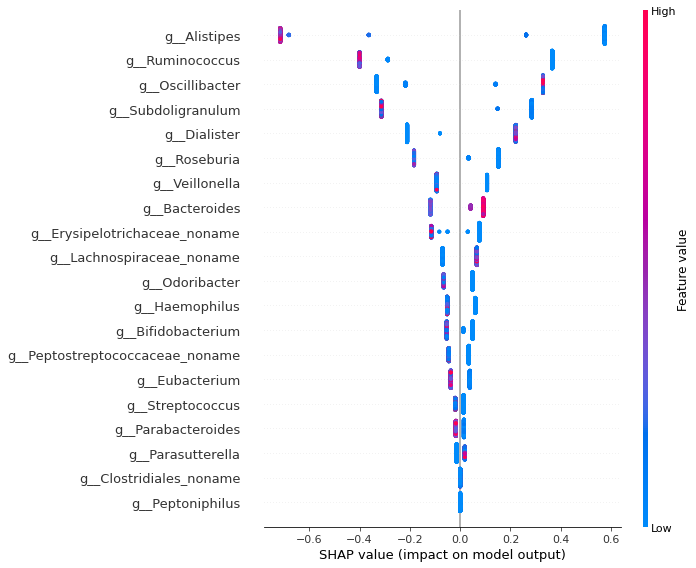

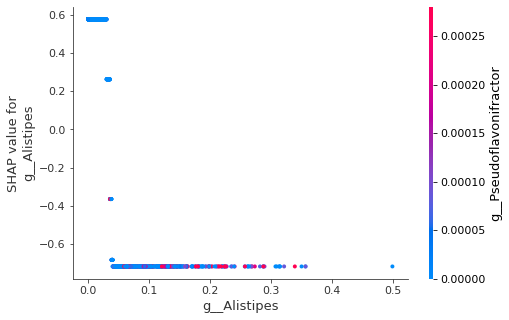

In [390]:
p_xgb, shap_feats_xgb = shap_feat(X_train_temp[0].drop(columns=['Participant ID']),\
                          y_train_temp[0].drop(columns=['Participant ID']), model_xgb, j=3)

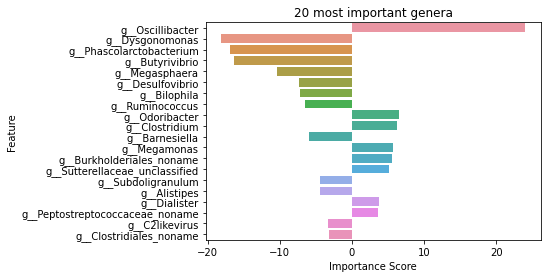

In [391]:
linear_feats_sgd = linear_feat(X_train_temp[0].drop(columns=['Participant ID']),\
                          y_train_temp[0].drop(columns=['Participant ID']), model_sgd, j=20)

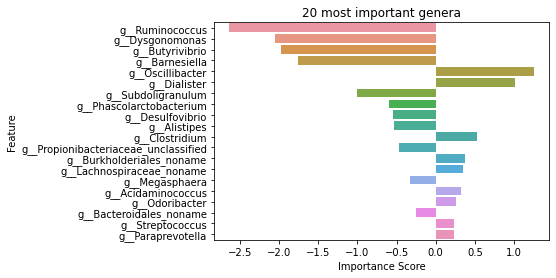

In [392]:
linear_feats_svc = linear_feat(X_train_temp[0].drop(columns=['Participant ID']),\
                          y_train_temp[0].drop(columns=['Participant ID']), model_svc, j=20)

In [393]:
mutual_info_feat = []
for k in tqdm(range(5, 100, 5)):
    mutual_info_feat.append(mutual_info(X_train_temp[0].drop(columns=['Participant ID']),\
    np.array(y_train_temp[0].drop(columns=['Participant ID'])).ravel(), k))

100%|██████████| 19/19 [01:08<00:00,  3.60s/it]


### Feature selection and training models again

In [394]:
ALL_selected_features = {'tree': [], 'shap': [], 'mutual_info': [], 'tree_xgb': [], 'shap_xgb': [], \
                        'svc': [], 'sgd': []}
ALL_selected_features['mutual_info'] = list(mutual_info_feat)

for k in range(5, 100, 5):
    ALL_selected_features['tree'].append(bestktree(tree_feats_rf, k))
    ALL_selected_features['tree_xgb'].append(bestktree(tree_feats_xgb, k))
    
    ALL_selected_features['shap'].append(bestkshap(X_train_temp[0].drop(columns=['Participant ID']), shap_feats_rf, k))
    ALL_selected_features['shap_xgb'].append(bestkshap(X_train_temp[0].drop(columns=['Participant ID']), shap_feats_xgb, k))
    
    ALL_selected_features['svc'].append(bestklinear(linear_feats_svc, k))
    ALL_selected_features['sgd'].append(bestklinear(linear_feats_sgd, k))

f1_rf = {'all': [f1_0_rf, f1_1_rf], 'tree': [[], []], 'shap': [[], []],\
         'mi': [[], []]}

f1_xgb = {'all': [f1_0_xgb, f1_1_xgb], 'tree': [[], []], 'shap': [[], []],\
         'mi': [[], []]}

f1_sgd = {'all': [f1_0_sgd, f1_1_sgd], 'svc': [[], []], 'sgd': [[], []], 'mi': [[], []]}

f1_svc = {'all': [f1_0_svc, f1_1_svc], 'svc': [[], []], 'sgd': [[], []], 'mi': [[], []]}

for i in tqdm(range(19)):
    feats_tree = ALL_selected_features['tree'][i]
    feats_tree_xgb = ALL_selected_features['tree_xgb'][i]
    
    feats_shap = ALL_selected_features['shap'][i]
    feats_shap_xgb = ALL_selected_features['shap_xgb'][i]
    
    feats_mi = list(ALL_selected_features['mutual_info'][i])
    feats_svc = ALL_selected_features['svc'][i]
    feats_sgd = ALL_selected_features['sgd'][i]
    
    for ft, f in zip([feats_svc, feats_sgd, feats_mi], ['svc', 'sgd', 'mi']):
        ftc = ft.copy()
        ftc.extend(['Participant ID'])

        X_train_temp_sel = [X_train_temp[0][ftc]]
        X_test_temp_sel = [X_test_temp[0][ftc]]
        
        _, f1_0_sgd, f1_1_sgd = sgd(X_train_temp_sel, X_test_temp_sel, y_train_temp, y_test_temp, j=5, output=False, disable=True)
        _, f1_0_svc, f1_1_svc = svc(X_train_temp_sel, X_test_temp_sel, y_train_temp, y_test_temp, j=5, output=False, disable=True)
        
        f1_sgd[f][0].append(f1_0_sgd[0])
        f1_sgd[f][1].append(f1_1_sgd[0])
        
        f1_svc[f][0].append(f1_0_svc[0])
        f1_svc[f][1].append(f1_1_svc[0])
    
    for ft, f in zip([feats_tree, feats_shap, feats_mi], ['tree', 'shap', 'mi']):
        ftc = ft.copy()
        ftc.extend(['Participant ID'])

        X_train_temp_sel = [X_train_temp[0][ftc]]
        X_test_temp_sel = [X_test_temp[0][ftc]]
        
        _, f1_0_rf, f1_1_rf = rfc2(X_train_temp_sel, X_test_temp_sel, y_train_temp, y_test_temp, j=5, output=False, disable=True)
        
        f1_rf[f][0].append(f1_0_rf[0])
        f1_rf[f][1].append(f1_1_rf[0])
    
    for ft, f in zip([feats_tree_xgb, feats_shap_xgb, feats_mi], ['tree', 'shap', 'mi']):
        ftc = ft.copy()
        ftc.extend(['Participant ID'])

        X_train_temp_sel = [X_train_temp[0][ftc]]
        X_test_temp_sel = [X_test_temp[0][ftc]]
        
        _, f1_0_xgb, f1_1_xgb = xgboost2(X_train_temp_sel, X_test_temp_sel, y_train_temp, y_test_temp, j=5, output=False, disable=True)
        
        f1_xgb[f][0].append(f1_0_xgb[0])
        f1_xgb[f][1].append(f1_1_xgb[0])


  0%|          | 0/19 [00:00<?, ?it/s]

Average best F1 for class 0:  0.21621621621621623
Average best F1 for class 1:  0.7030716723549488
Average best F1 for class 0:  0.35978835978835977
Average best F1 for class 1:  0.4372093023255814
Average best F1 for class 0:  0.30903790087463556
Average best F1 for class 1:  0.49032258064516127


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Average best F1 for class 0:  0.14864864864864866
Average best F1 for class 1:  0.8090909090909092
Average best F1 for class 0:  0.029411764705882353
Average best F1 for class 1:  0.8035714285714286


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Average best F1 for class 0:  0.23529411764705885
Average best F1 for class 1:  0.6807017543859648
Average best F1 for class 0:  0.2823529411764706
Average best F1 for class 1:  0.6690777576853526
Average best F1 for class 0:  0.2823529411764706
Average best F1 for class 1:  0.6690777576853526
Average best F1 for class 0:  0.23863636363636362
Average best F1 for class 1:  0.7879746835443039
Average best F1 for class 0:  0.352059925093633
Average best F1 for class 1:  0.6802218114602587
Average best F1 for class 0:  0.352059925093633
Average best F1 for class 1:  0.6802218114602587


  5%|▌         | 1/19 [00:06<02:04,  6.91s/it]

Average best F1 for class 0:  0.27906976744186046
Average best F1 for class 1:  0.7386172006745363
Average best F1 for class 0:  0.20717131474103584
Average best F1 for class 1:  0.6427289048473969
Average best F1 for class 0:  0.19742489270386268
Average best F1 for class 1:  0.6747826086956522
Average best F1 for class 0:  0.2488479262672811
Average best F1 for class 1:  0.7241962774957699
Average best F1 for class 0:  0.2872340425531915
Average best F1 for class 1:  0.7838709677419355
Average best F1 for class 0:  0.2787456445993031
Average best F1 for class 1:  0.6026871401151632
Average best F1 for class 0:  0.3275862068965517
Average best F1 for class 1:  0.491304347826087
Average best F1 for class 0:  0.18705035971223022
Average best F1 for class 1:  0.5735849056603773
Average best F1 for class 0:  0.225
Average best F1 for class 1:  0.6725352112676056
Average best F1 for class 0:  0.2682926829268293
Average best F1 for class 1:  0.6797153024911032
Average best F1 for class 0:  

 11%|█         | 2/19 [00:14<02:00,  7.08s/it]

Average best F1 for class 0:  0.2551440329218107
Average best F1 for class 1:  0.679646017699115
Average best F1 for class 0:  0.2339622641509434
Average best F1 for class 1:  0.6261510128913443
Average best F1 for class 0:  0.226890756302521
Average best F1 for class 1:  0.6771929824561402
Average best F1 for class 0:  0.24573378839590448
Average best F1 for class 1:  0.570873786407767
Average best F1 for class 0:  0.26936026936026936
Average best F1 for class 1:  0.5753424657534247
Average best F1 for class 0:  0.32515337423312884
Average best F1 for class 1:  0.5435684647302904
Average best F1 for class 0:  0.25
Average best F1 for class 1:  0.6830985915492959
Average best F1 for class 0:  0.19827586206896552
Average best F1 for class 1:  0.6770833333333333
Average best F1 for class 0:  0.2447552447552447
Average best F1 for class 1:  0.5862068965517241
Average best F1 for class 0:  0.35684647302904565
Average best F1 for class 1:  0.7266313932980599
Average best F1 for class 0:  0.

 16%|█▌        | 3/19 [00:21<01:55,  7.22s/it]

Average best F1 for class 0:  0.2692307692307692
Average best F1 for class 1:  0.7466666666666667
Average best F1 for class 0:  0.22413793103448276
Average best F1 for class 1:  0.6875
Average best F1 for class 0:  0.2317596566523605
Average best F1 for class 1:  0.688695652173913
Average best F1 for class 0:  0.23140495867768593
Average best F1 for class 1:  0.6713780918727915
Average best F1 for class 0:  0.2077922077922078
Average best F1 for class 1:  0.6828422876949739
Average best F1 for class 0:  0.27636363636363637
Average best F1 for class 1:  0.626641651031895
Average best F1 for class 0:  0.23829787234042554
Average best F1 for class 1:  0.68760907504363
Average best F1 for class 0:  0.21145374449339208
Average best F1 for class 1:  0.6919104991394147
Average best F1 for class 0:  0.18433179723502302
Average best F1 for class 1:  0.700507614213198
Average best F1 for class 0:  0.3629032258064516
Average best F1 for class 1:  0.7178571428571429
Average best F1 for class 0:  0

 21%|██        | 4/19 [00:29<01:50,  7.40s/it]

Average best F1 for class 0:  0.3541666666666667
Average best F1 for class 1:  0.6423076923076924
Average best F1 for class 0:  0.27631578947368424
Average best F1 for class 1:  0.5634920634920635
Average best F1 for class 0:  0.2317596566523605
Average best F1 for class 1:  0.688695652173913
Average best F1 for class 0:  0.2288135593220339
Average best F1 for class 1:  0.6818181818181818
Average best F1 for class 0:  0.21551724137931033
Average best F1 for class 1:  0.6840277777777778
Average best F1 for class 0:  0.31952662721893493
Average best F1 for class 1:  0.5106382978723404
Average best F1 for class 0:  0.32352941176470584
Average best F1 for class 1:  0.5085470085470086
Average best F1 for class 0:  0.26755852842809363
Average best F1 for class 1:  0.5697445972495089
Average best F1 for class 0:  0.2062780269058296
Average best F1 for class 1:  0.6974358974358974
Average best F1 for class 0:  0.18666666666666665
Average best F1 for class 1:  0.6861063464837049
Average best F1

 26%|██▋       | 5/19 [00:37<01:45,  7.56s/it]

Average best F1 for class 0:  0.18834080717488788
Average best F1 for class 1:  0.6905982905982906
Average best F1 for class 0:  0.24166666666666667
Average best F1 for class 1:  0.6795774647887325
Average best F1 for class 0:  0.2317596566523605
Average best F1 for class 1:  0.688695652173913
Average best F1 for class 0:  0.2528735632183908
Average best F1 for class 1:  0.643510054844607
Average best F1 for class 0:  0.21551724137931033
Average best F1 for class 1:  0.6840277777777778
Average best F1 for class 0:  0.32764505119453924
Average best F1 for class 1:  0.6174757281553398
Average best F1 for class 0:  0.25531914893617025
Average best F1 for class 1:  0.694589877835951
Average best F1 for class 0:  0.2866666666666667
Average best F1 for class 1:  0.578740157480315
Average best F1 for class 0:  0.2706270627062706
Average best F1 for class 1:  0.5623762376237623
Average best F1 for class 0:  0.27831715210355984
Average best F1 for class 1:  0.5531062124248497
Average best F1 fo

 32%|███▏      | 6/19 [00:45<01:41,  7.79s/it]

Average best F1 for class 0:  0.20512820512820515
Average best F1 for class 1:  0.6759581881533101
Average best F1 for class 0:  0.2635658914728682
Average best F1 for class 1:  0.6545454545454545
Average best F1 for class 0:  0.2920634920634921
Average best F1 for class 1:  0.5476673427991886
Average best F1 for class 0:  0.2509803921568627
Average best F1 for class 1:  0.654611211573237
Average best F1 for class 0:  0.2260869565217391
Average best F1 for class 1:  0.6920415224913494
Average best F1 for class 0:  0.2753036437246963
Average best F1 for class 1:  0.6809269162210339
Average best F1 for class 0:  0.2445414847161572
Average best F1 for class 1:  0.701208981001727
Average best F1 for class 0:  0.31775700934579443
Average best F1 for class 1:  0.5503080082135524
Average best F1 for class 0:  0.2588996763754045
Average best F1 for class 1:  0.5410821643286573
Average best F1 for class 0:  0.2184873949579832
Average best F1 for class 1:  0.6736842105263158
Average best F1 for 

 37%|███▋      | 7/19 [00:58<01:56,  9.67s/it]

Average best F1 for class 0:  0.20689655172413793
Average best F1 for class 1:  0.6805555555555556
Average best F1 for class 0:  0.25899280575539574
Average best F1 for class 1:  0.611320754716981
Average best F1 for class 0:  0.2278481012658228
Average best F1 for class 1:  0.6795096322241682
Average best F1 for class 0:  0.2698412698412698
Average best F1 for class 1:  0.6690647482014388
Average best F1 for class 0:  0.26262626262626265
Average best F1 for class 1:  0.5714285714285715
Average best F1 for class 0:  0.2595419847328244
Average best F1 for class 1:  0.6446886446886448
Average best F1 for class 0:  0.2368421052631579
Average best F1 for class 1:  0.7000000000000001
Average best F1 for class 0:  0.27848101265822783
Average best F1 for class 1:  0.5365853658536586
Average best F1 for class 0:  0.30921052631578955
Average best F1 for class 1:  0.5833333333333333
Average best F1 for class 0:  0.136986301369863
Average best F1 for class 1:  0.8096676737160121
Average best F1 f

 42%|████▏     | 8/19 [01:16<02:13, 12.17s/it]

Average best F1 for class 0:  0.18103448275862066
Average best F1 for class 1:  0.6701388888888888
Average best F1 for class 0:  0.2614840989399293
Average best F1 for class 1:  0.6019047619047618
Average best F1 for class 0:  0.23430962343096234
Average best F1 for class 1:  0.6783831282952548
Average best F1 for class 0:  0.25830258302583026
Average best F1 for class 1:  0.6256983240223464
Average best F1 for class 0:  0.28196721311475414
Average best F1 for class 1:  0.5646123260437376
Average best F1 for class 0:  0.15053763440860216
Average best F1 for class 1:  0.7459807073954985
Average best F1 for class 0:  0.23931623931623933
Average best F1 for class 1:  0.6898954703832754
Average best F1 for class 0:  0.3072100313479624
Average best F1 for class 1:  0.5480572597137015
Average best F1 for class 0:  0.1836734693877551
Average best F1 for class 1:  0.738562091503268
Average best F1 for class 0:  0.31921824104234525
Average best F1 for class 1:  0.5828343313373253
Average best F

 47%|████▋     | 9/19 [01:25<01:51, 11.18s/it]

Average best F1 for class 0:  0.24896265560165975
Average best F1 for class 1:  0.6807760141093475
Average best F1 for class 0:  0.20444444444444446
Average best F1 for class 1:  0.692967409948542
Average best F1 for class 0:  0.24166666666666667
Average best F1 for class 1:  0.6795774647887325
Average best F1 for class 0:  0.248
Average best F1 for class 1:  0.6630824372759857
Average best F1 for class 0:  0.2770270270270271
Average best F1 for class 1:  0.58203125
Average best F1 for class 0:  0.2619047619047619
Average best F1 for class 1:  0.6654676258992805
Average best F1 for class 0:  0.2368421052631579
Average best F1 for class 1:  0.7000000000000001
Average best F1 for class 0:  0.26366559485530544
Average best F1 for class 1:  0.5392354124748491
Average best F1 for class 0:  0.27184466019417475
Average best F1 for class 1:  0.5490981963927855
Average best F1 for class 0:  0.28758169934640526
Average best F1 for class 1:  0.5657370517928287
Average best F1 for class 0:  0.2367

 53%|█████▎    | 10/19 [01:34<01:35, 10.65s/it]

Average best F1 for class 0:  0.17857142857142858
Average best F1 for class 1:  0.6849315068493151
Average best F1 for class 0:  0.25101214574898784
Average best F1 for class 1:  0.6702317290552585
Average best F1 for class 0:  0.25
Average best F1 for class 1:  0.6830985915492959
Average best F1 for class 0:  0.32
Average best F1 for class 1:  0.6491557223264541
Average best F1 for class 0:  0.29220779220779225
Average best F1 for class 1:  0.564
Average best F1 for class 0:  0.21551724137931033
Average best F1 for class 1:  0.6840277777777778
Average best F1 for class 0:  0.23829787234042554
Average best F1 for class 1:  0.68760907504363
Average best F1 for class 0:  0.2445141065830721
Average best F1 for class 1:  0.507157464212679
Average best F1 for class 0:  0.21645021645021648
Average best F1 for class 1:  0.6863084922010398
Average best F1 for class 0:  0.22448979591836735
Average best F1 for class 1:  0.556420233463035
Average best F1 for class 0:  0.26229508196721313
Average 

 58%|█████▊    | 11/19 [01:44<01:22, 10.29s/it]

Average best F1 for class 0:  0.14772727272727273
Average best F1 for class 1:  0.7626582278481013
Average best F1 for class 0:  0.25190839694656486
Average best F1 for class 1:  0.6410256410256411
Average best F1 for class 0:  0.29032258064516125
Average best F1 for class 1:  0.5582329317269076
Average best F1 for class 0:  0.28368794326241137
Average best F1 for class 1:  0.6159695817490494
Average best F1 for class 0:  0.28104575163398693
Average best F1 for class 1:  0.5617529880478088
Average best F1 for class 0:  0.3202416918429003
Average best F1 for class 1:  0.5283018867924528
Average best F1 for class 0:  0.2307692307692308
Average best F1 for class 1:  0.6864111498257839
Average best F1 for class 0:  0.2588996763754045
Average best F1 for class 1:  0.5410821643286573
Average best F1 for class 0:  0.26198083067092653
Average best F1 for class 1:  0.5333333333333334
Average best F1 for class 0:  0.24605678233438485
Average best F1 for class 1:  0.5132382892057026
Average best 

 63%|██████▎   | 12/19 [01:53<01:10, 10.12s/it]

Average best F1 for class 0:  0.10666666666666667
Average best F1 for class 1:  0.6552315608919382
Average best F1 for class 0:  0.30322580645161284
Average best F1 for class 1:  0.5662650602409638
Average best F1 for class 0:  0.23728813559322035
Average best F1 for class 1:  0.6853146853146852
Average best F1 for class 0:  0.2424242424242424
Average best F1 for class 1:  0.6967071057192376
Average best F1 for class 0:  0.2838283828382838
Average best F1 for class 1:  0.5702970297029704
Average best F1 for class 0:  0.2846715328467153
Average best F1 for class 1:  0.6329588014981273
Average best F1 for class 0:  0.29042904290429045
Average best F1 for class 1:  0.5742574257425742
Average best F1 for class 0:  0.19095477386934676
Average best F1 for class 1:  0.7356321839080459
Average best F1 for class 0:  0.2572347266881029
Average best F1 for class 1:  0.5352112676056339
Average best F1 for class 0:  0.264406779661017
Average best F1 for class 1:  0.5769980506822613
Average best F1 

 68%|██████▊   | 13/19 [02:03<01:00, 10.07s/it]

Average best F1 for class 0:  0.17391304347826086
Average best F1 for class 1:  0.671280276816609
Average best F1 for class 0:  0.27027027027027023
Average best F1 for class 1:  0.6557377049180328
Average best F1 for class 0:  0.24166666666666667
Average best F1 for class 1:  0.6795774647887325
Average best F1 for class 0:  0.25203252032520324
Average best F1 for class 1:  0.6725978647686833
Average best F1 for class 0:  0.29032258064516125
Average best F1 for class 1:  0.5582329317269076
Average best F1 for class 0:  0.26717557251908397
Average best F1 for class 1:  0.6483516483516484
Average best F1 for class 0:  0.31023102310231027
Average best F1 for class 1:  0.5861386138613861
Average best F1 for class 0:  0.2547770700636943
Average best F1 for class 1:  0.5263157894736842
Average best F1 for class 0:  0.30670926517571884
Average best F1 for class 1:  0.5616161616161617
Average best F1 for class 0:  0.27848101265822783
Average best F1 for class 1:  0.5365853658536586
Average best

 74%|███████▎  | 14/19 [02:13<00:50, 10.04s/it]

Average best F1 for class 0:  0.11353711790393013
Average best F1 for class 1:  0.6493955094991365
Average best F1 for class 0:  0.2826086956521739
Average best F1 for class 1:  0.6278195488721805
Average best F1 for class 0:  0.24267782426778245
Average best F1 for class 1:  0.6818980667838311
Average best F1 for class 0:  0.2363636363636364
Average best F1 for class 1:  0.7142857142857144
Average best F1 for class 0:  0.29392971246006394
Average best F1 for class 1:  0.5535353535353534
Average best F1 for class 0:  0.27215189873417717
Average best F1 for class 1:  0.532520325203252
Average best F1 for class 0:  0.3010033444816054
Average best F1 for class 1:  0.5893909626719057
Average best F1 for class 0:  0.26031746031746034
Average best F1 for class 1:  0.5273833671399595
Average best F1 for class 0:  0.19289340101522842
Average best F1 for class 1:  0.7397708674304418
Average best F1 for class 0:  0.29967426710097717
Average best F1 for class 1:  0.5708582834331338
Average best F

 79%|███████▉  | 15/19 [02:23<00:40, 10.03s/it]

Average best F1 for class 0:  0.18181818181818182
Average best F1 for class 1:  0.6724436741767763
Average best F1 for class 0:  0.27586206896551724
Average best F1 for class 1:  0.5945945945945945
Average best F1 for class 0:  0.24066390041493776
Average best F1 for class 1:  0.6772486772486773
Average best F1 for class 0:  0.2633744855967078
Average best F1 for class 1:  0.6831858407079646
Average best F1 for class 0:  0.28938906752411575
Average best F1 for class 1:  0.5553319919517102
Average best F1 for class 0:  0.17840375586854457
Average best F1 for class 1:  0.7058823529411764
Average best F1 for class 0:  0.2885245901639344
Average best F1 for class 1:  0.5685884691848907
Average best F1 for class 0:  0.27476038338658143
Average best F1 for class 1:  0.5414141414141415
Average best F1 for class 0:  0.3081761006289308
Average best F1 for class 1:  0.5510204081632654
Average best F1 for class 0:  0.2684563758389262
Average best F1 for class 1:  0.5725490196078431
Average best F

 84%|████████▍ | 16/19 [02:34<00:30, 10.15s/it]

Average best F1 for class 0:  0.18099547511312214
Average best F1 for class 1:  0.6916524701873935
Average best F1 for class 0:  0.30405405405405406
Average best F1 for class 1:  0.59765625
Average best F1 for class 0:  0.22978723404255322
Average best F1 for class 1:  0.6841186736474694
Average best F1 for class 0:  0.3232323232323232
Average best F1 for class 1:  0.6066536203522505
Average best F1 for class 0:  0.23628691983122363
Average best F1 for class 1:  0.6830122591943958
Average best F1 for class 0:  0.26771653543307083
Average best F1 for class 1:  0.6642599277978339
Average best F1 for class 0:  0.21524663677130043
Average best F1 for class 1:  0.7008547008547008
Average best F1 for class 0:  0.28289473684210525
Average best F1 for class 1:  0.5674603174603174
Average best F1 for class 0:  0.20512820512820512
Average best F1 for class 1:  0.7471451876019576
Average best F1 for class 0:  0.2290748898678414
Average best F1 for class 1:  0.6987951807228916
Average best F1 for 

 89%|████████▉ | 17/19 [02:44<00:20, 10.23s/it]

Average best F1 for class 0:  0.17272727272727273
Average best F1 for class 1:  0.6904761904761905
Average best F1 for class 0:  0.299625468164794
Average best F1 for class 1:  0.6543438077634011
Average best F1 for class 0:  0.2920634920634921
Average best F1 for class 1:  0.5476673427991886
Average best F1 for class 0:  0.30322580645161284
Average best F1 for class 1:  0.5662650602409638
Average best F1 for class 0:  0.23333333333333334
Average best F1 for class 1:  0.676056338028169
Average best F1 for class 0:  0.23673469387755103
Average best F1 for class 1:  0.6678507992895205
Average best F1 for class 0:  0.2857142857142857
Average best F1 for class 1:  0.5759368836291913
Average best F1 for class 0:  0.1935483870967742
Average best F1 for class 1:  0.7588424437299036
Average best F1 for class 0:  0.28037383177570097
Average best F1 for class 1:  0.5256673511293635
Average best F1 for class 0:  0.1925133689839572
Average best F1 for class 1:  0.7568438003220611
Average best F1 f

 95%|█████████▍| 18/19 [02:55<00:10, 10.35s/it]

Average best F1 for class 0:  0.15384615384615383
Average best F1 for class 1:  0.7762128325508608
Average best F1 for class 0:  0.31864406779661014
Average best F1 for class 1:  0.608187134502924
Average best F1 for class 0:  0.28196721311475414
Average best F1 for class 1:  0.5646123260437376
Average best F1 for class 0:  0.2947368421052632
Average best F1 for class 1:  0.6156787762906308
Average best F1 for class 0:  0.22127659574468087
Average best F1 for class 1:  0.680628272251309
Average best F1 for class 0:  0.26666666666666666
Average best F1 for class 1:  0.6319702602230484
Average best F1 for class 0:  0.3006535947712418
Average best F1 for class 1:  0.5737051792828686
Average best F1 for class 0:  0.2893081761006289
Average best F1 for class 1:  0.5387755102040817
Average best F1 for class 0:  0.17708333333333334
Average best F1 for class 1:  0.7435064935064936
Average best F1 for class 0:  0.18340611353711792
Average best F1 for class 1:  0.6770293609671848
Average best F1

100%|██████████| 19/19 [03:06<00:00,  9.79s/it]

Average best F1 for class 0:  0.12093023255813953
Average best F1 for class 1:  0.6812816188870152


### Model performance with respect to number of features

In [395]:

#plot f1 wrt numbers of features
def f1_plot(f1_model, title, markers):
    X = list(range(5, 100, 5))
#     X = [30, 35, 40]
    
    plt.figure()
    
    # plot perfor
    plt.hlines(f1_model['all'][0], xmin=5, xmax=100, colors='green', linestyles='solid', label='all features, class 0')
    plt.hlines(f1_model['all'][1], xmin=5, xmax=100, colors='yellow', linestyles='solid', label='all features, class 1')
    
    for f, m in zip(list(f1_model.keys())[1:], markers):
        plt.plot(X, f1_model[f][0], label=f'{f}, class 0', linestyle=m, color='blue')
        plt.plot(X, f1_model[f][1], label=f'{f}, class 1', linestyle=m, color='red')
    plt.legend(bbox_to_anchor=(1.05, 1.025))
    plt.xlabel('Number of features')
    plt.ylabel('F1-score')
    plt.title(f'{title} F1 scores')
    plt.figure()
    
    plt.show()

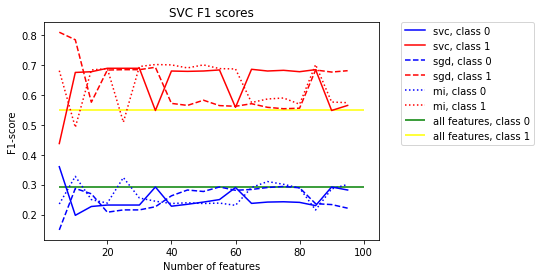

<Figure size 432x288 with 0 Axes>

In [400]:
f1_plot(f1_svc, 'SVC', markers = ['-', '--', ':'])

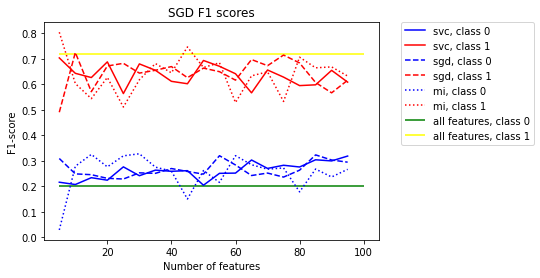

<Figure size 432x288 with 0 Axes>

In [397]:
f1_plot(f1_sgd, 'SGD', markers = ['-', '--', ':'])

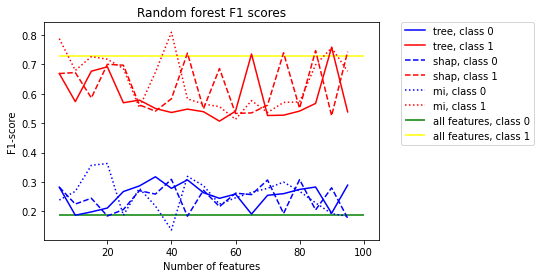

<Figure size 432x288 with 0 Axes>

In [398]:
f1_plot(f1_rf, 'Random forest', markers = ['-', '--', ':'])

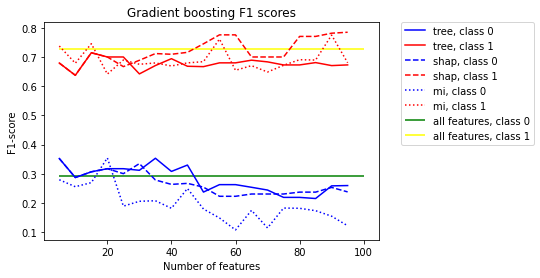

<Figure size 432x288 with 0 Axes>

In [399]:
f1_plot(f1_xgb, 'Gradient boosting', markers = ['-', '--', ':'])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2609b90e-251e-426c-b0d0-07040df3c126' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>